This notebook aims to explore model fitting of GLM-HMM with 3 categories to encapsulate animal 'no-lick' responses. This will first be done using a 1-state GLM-HMM (i.e. just a GLM) as a sanity check. Then an estimate for the number of sessions needed from a given mouse to reliably fit HMM-GLM models will be determined. The strategy for this determination is as follows: 1) fit a model to existing data for a single animal, 2) generate synthetic stimuli sets that are similar to stimuli utilized in the experiments, 3) using this stimuli and the fit model, generate mouse responses, 4) for increasing number of sessions, fit a second HMM-GLM to this generated data to determine how many sessions are required to recapture the model parameters in the second HMM-GLM that were used in the original, generative model.

The code in the notebook was adapted from a notebook prepared by Zoe Ashwood in support of the Ashwood et al. (2020) publication "Mice alternate between discrete strategies during perceptual decision-making".

In [1]:
from uobrainflex.nwb import loadbehavior as load
from uobrainflex.behavioranalysis import flex_hmm
import ssm
from ssm.util import one_hot, find_permutation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import KFold

In [32]:
#Model selection functions
def psychometrics(w,stim):
    # w is an np array of dim (C-1,2) with weights for the first 2 choices in a given state
    # stim is a list of stimulus values of length S
    # psycho_out is a psychometric curve for each category with dim (C,S) including the 3rd choice
    stim1=np.vstack((np.array(stim).T,np.ones(len(stim))))
    denom=1+np.sum(np.exp(w.dot(stim1)),0) # normalization factor 
    denom=np.tile(denom,(w.shape[0]+1,1)) # tile normalization factor 
    psycho_out=np.vstack((np.exp(w.dot(stim1)),np.ones(len(stim))))/denom
    return psycho_out
#helper functions
#fit model
def fitModel(subject_dict, num_states, obs_dim, num_categories, input_dim):
    #dictionaries to store model parameters
    model_dict = {}
    param_dict = {}
    data_dict = {}
    ######Get the Data#######
    sessions=[]
    subject = list(subject_dict.keys())[0]
    date_start = subject_dict[subject][0]
    date_end = subject_dict[subject][1]
    for fileID in range(date_start, date_end):
        this_session = load.get_file_path(subject,str(fileID))
        if this_session:
            sessions.append(this_session)

    inpts=list([])
    true_choices=list([])
    sessions_trial_start =list([])
    #sessions_response_inds = list([])
    for sess in sessions:
        trial_data, trial_labels = load.load_trial_data(sess)
        these_inpts, these_true_choices, trial_start = flex_hmm.format_all_behavior_hmm(trial_data, trial_labels)
        inpts.extend(these_inpts)
        true_choices.extend([these_true_choices])
        sessions_trial_start.extend([trial_start])
        #sessions_response_inds.extend([response_inds])

    ####Fit GLM-HMM
    ###### Fit GLM-HMM with MAP estimation:
    # Instantiate GLM-HMM and set prior hyperparameters (MAP version)
    prior_sigma = 2
    prior_alpha = 2

    sub_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                         observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                         transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

    N_iters = 200
    fit_sub_ll = sub_glmhmm.fit(true_choices, inputs=inpts, verbose=1, method="em", num_iters=N_iters,
                                tolerance=10**-4)

    plotModelParams(sub_glmhmm)
    model_dict[subject] = sub_glmhmm#add GLM-HMM model to dictionary of all fit GLM-HMMs
    param_dict[subject] = {'GLM_weights': sub_glmhmm.observations.params, 
                           'HMM_probs': sub_glmhmm.transitions.log_Ps}
    data_dict[subject] = {'inpts': inpts, 
                           'true_choices': true_choices}
    return fit_sub_ll, model_dict, param_dict, data_dict
# Plot generative parameters:
def plotModelParams(map_glmhmm, max_states=None):
    params = map_glmhmm.observations.params
    num_states = params.shape[0]
    input_dim = params.shape[2]
    cmap = plt.get_cmap("tab10")#get 'tab10' color map to pull indices from to use for plotting individual model results
    if max_states is None:
        c_inds = np.linspace(0.0, 1.0, num=num_states)#grab indices for colors for 7 model types across the range of 'tab10' color values
    else:
        c_inds = np.linspace(0.0, 1.0, num=max_states)#grab indices for colors for 7 model types across the range of 'tab10' color values
    cols = cmap(c_inds)#map those indices to a list colors
    fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)

    #cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
    for k in range(num_states):
        plt.plot(range(input_dim), params[k,:][0]*-1, marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="state " + str(k+1))
    plt.yticks(fontsize=10)
    plt.ylabel("GLM weight", fontsize=15)
    plt.xlabel("covariate", fontsize=15)
    plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
    plt.axhline(y=0, color="k", alpha=0.5, ls="--")
    plt.legend()
    plt.title("Generative weights", fontsize = 15)

    plt.subplot(1, 2, 2)
    gen_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
    plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
    for i in range(gen_trans_mat.shape[0]):
        for j in range(gen_trans_mat.shape[1]):
            text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                            color="k", fontsize=12)
    plt.xlim(-0.5, num_states - 0.5)
    tick_labels = [str(i) for i in range(1, num_states+1)]
    plt.xticks(range(0, num_states), tick_labels, fontsize=10)
    plt.yticks(range(0, num_states), tick_labels, fontsize=10)
    plt.ylim(num_states - 0.5, -0.5)
    plt.ylabel("state t", fontsize = 15)
    plt.xlabel("state t+1", fontsize = 15)
    plt.title("Generative transition matrix", fontsize = 15)

def plotModelBehav(map_glmhmm, inpts, true_choices, stim_vals, title, max_states=None, occ_thresh=None):
    params = map_glmhmm.observations.params
    
    num_states = params.shape[0]
    
    cmap = plt.get_cmap("tab10")#get 'tab10' color map to pull indices from to use for plotting individual model results
    if max_states is not None:
        c_inds = np.linspace(0.0, 1.0, num=max_states)#grab indices for colors for 7 model types across the range of 'tab10' color values
    else:
        c_inds = np.linspace(0.0, 1.0, num=num_states)#grab indices for colors for 7 model types across the range of 'tab10' color values
    cols = cmap(c_inds)#map those indices to a list colors
    #plot dwell times
    # Get expected states:
    posterior_probs = [map_glmhmm.expected_states(data=data, input=inpt)[0]
                       for data, inpt
                       in zip(true_choices, inpts)]
    # concatenate posterior probabilities across sessions
    posterior_probs_concat = np.concatenate(posterior_probs)
    #if a state occupancy threshold is indicated
    if occ_thresh is not None:
        state_max_posterior = []
        # get only state with posterior probability above occ_thresh for a particular trial:
        for i in range(posterior_probs_concat.shape[0]):#iterate across all trials
            trial_probs = posterior_probs_concat[i,:]#posterior probs for the states of this trial
            gt_inds = np.argwhere(trial_probs > occ_thresh)#greater than indices
            if len(gt_inds) != 1:#if more than one ind above threshold or if no states are above threshold
                #append a "undecided" state equivalent to 1 + the max_state
                state_max_posterior.append(len(trial_probs)+1)
            else:
                state_max_posterior.append(gt_inds[0][0])
    else:
        # get state with maximum posterior probability at particular trial:
        state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
    # now obtain state fractional occupancies:
    unique_states, state_occupancies = np.unique(state_max_posterior, return_counts=True)
    state_occupancies = state_occupancies/np.sum(state_occupancies)
    
    if occ_thresh is not None:
        #have to subtract 1 from len of state_occupancies because
        #it contains an extra state for 'undecided'
        unocc_states = len(state_occupancies)-1 < num_states
    else:
        unocc_states = len(state_occupancies) < num_states
    
    if unocc_states:
        #find what state is never occupied
        possible_states = list(range(num_states))
        missed_states  = set(possible_states) ^ set(unique_states) #use symmetric difference operator
        count = 0#keep track of number of states inserted
        for ms in missed_states:# insert 0.0 for missed states
            if ms < unique_states[-1]:
                insert_ind = np.argmin([i for i,v in enumerate(unique_states) if v > ms]) - 1
                state_occupancies = np.insert(state_occupancies, insert_ind, 0.0)
            else:
                state_occupancies = np.append(state_occupancies, 0.0)
            count+=1#keeps track of how much the array is lengthened so correct indices are used each time

    #plot
    fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
    if max_states is not None:
        max_range = max_states+1
    else:
        max_range = num_states+1
    tick_labels = [str(i) for i in range(1, max_range)]
    if occ_thresh is not None:
        max_range +=1#add one more xtick to account for 'undecided' state
        tick_labels.append('undecided')
        
    for z, occ in enumerate(state_occupancies):
        if z >= num_states:#if a state is ever found that is greater than the number of states
            #this means we are plotting the 'undecided' state
            plt.bar(max_range-1, occ, width = 0.8, color = 'k', hatch='/', alpha=0.1)
        else:
            plt.bar(z+1, occ, width = 0.8, color = cols[z])

    plt.xticks(range(1, max_range), tick_labels, fontsize = 10, rotation=20)
    plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
    plt.ylim((0, 1))
    plt.xlabel('state', fontsize = 15)
    plt.ylabel('frac. occupancy', fontsize=15)
    plt.title(str(num_states) + ' States, ' + title)
    plt.show()
    #plt.savefig("state_occupancy.svg")
    
    #plot psycometric curve
    ### generate psychometrics per state
    #concatenate inpts and choices
#     inpts_concat = np.concatenate(inpts)
#     trial_inpts = inpts_concat[:,0]
#     choice_concat = np.concatenate(true_choices)
    
#     state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
#     state_inpt_choice = pd.DataFrame(data=[],index=np.unique(state_max_posterior), columns = np.unique(trial_inpts))
#     trial_n = pd.DataFrame(data=[],index=np.unique(state_max_posterior), columns = np.unique(trial_inpts))
#     for iState in range(0,num_states):
#         state_ind = np.where(state_max_posterior == iState)[0].astype(int)
#         state_inpts = trial_inpts[state_ind]
#         state_choices = choice_concat[state_ind]
#         for iInp in np.unique(state_inpts):
#             these_trials = np.where(state_inpts == iInp)[0]
#             #if iInp > 0:
#                 #correct_choice = 1
#                 #mult=1
#             #if iInp <0:
#                 #correct_choice = 0
#                 #mult=-1
#             #state_inpt_choice.loc[iState,iInp] = len(np.where(state_choices[these_trials]==correct_choice)[0])/len(these_trials)*mult
#             state_inpt_choice.loc[iState,iInp] = len(np.where(state_choices[these_trials]==1)[0])/len(these_trials)
#             trial_n.loc[iState,iInp] =len(these_trials)

#     for iInp in np.unique(trial_inpts):
#         these_trials = np.where(trial_inpts == iInp)[0]
#         state_inpt_choice.loc['all_trials',iInp] = len(np.where(choice_concat[these_trials]==1)[0])/len(these_trials)
#         trial_n.loc['all_trials',iInp] = len(these_trials)

#     actual_inpts = stim_vals
#     state_inpt_choice.columns = actual_inpts
#     fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
#     plt.xlabel('Stimulus')
#     plt.ylabel('Right Choice Probability')
#     plt.title(str(num_states) + ' States Performance,' + title)
#     for idx in state_inpt_choice.index:
#         if idx == 'all_trials':
#             plt.plot(state_inpt_choice.loc[idx,:],'k--',marker='o')
#         if idx != 'all_trials':
#             plt.plot(state_inpt_choice.loc[idx,:],marker='o', color=cols[idx])   
#     #plt.savefig("performance_by_state.svg")
#     plt.show()
    
    #All choices psychometrics from GLM weights and stim values
    gen_weights = map_glmhmm.observations.params
    fig = plt.subplots(1, gen_weights.shape[1], sharey='all', figsize=(18, 3), dpi=80, facecolor='w', edgecolor='k')
    name_categories = ['L', 'R', 'Miss']
    # fig = plt.figure(figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
    #cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
    for iC in range(gen_weights.shape[1]+1):
        plt.subplot(1, gen_weights.shape[1]+1, iC+1)
        for k in range(num_states):
            psycho_out=psychometrics(gen_weights[k],stim_vals)
            plt.plot(stim_vals, psycho_out[iC], marker='o',
                     color=cols[k], linestyle='-',
                     lw=1.5, label="state " + str(k+1))
        plt.yticks(fontsize=10)
        plt.ylim((0.0, 1.0))
        plt.ylabel('p(y={} | stim)'.format(name_categories[iC]), fontsize=10)
        plt.legend()
        plt.title('Weights for {}'.format(name_categories[iC]), fontsize = 15)
    plt.show()
    
    # Get expected states:
    fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
    sess_id = 0 #session id; can choose any index between 0 and num_sess-1
    for k in range(num_states):
        plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
                 color=cols[k])
    plt.ylim((-0.01, 1.01))
    plt.yticks([0, 0.5, 1], fontsize = 10)
    plt.xlabel("trial #", fontsize = 15)
    plt.ylabel("p(state)", fontsize = 15)
    plt.show()
    
#     # overlay true state sequence
#     fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
#     for k in range(num_states):
#         plt.plot(true_latents[sess_id][:]==k,color=cols[k])
#     plt.yticks(None, fontsize = 10)
#     plt.yticks([0, 1], fontsize = 10)
#     plt.ylabel("true state", fontsize = 15)
#     plt.title(str(num_states) + ' Post. Prob.,' + title)
#     plt.show()
    
def makeModel(num_states, obs_dim, num_categories, input_dim,
                               subject_params, plot = True):
    """
    Initialize ground truth model for parameter recovery analysis.
    Parameters
    ----------
    num_states : scalar
        number of discrete states.
    obs_dim : scalar
        number of observed dimensions.
    num_categories : scalar
        number of categories for output
    input_dim : scalar
        number of input data dimensions
    Returns
    -------
    true_glmhmm : HMM-GLM model object
        GLM-HMM with MAP estimation object with specified parameters.
    """
    ###### Fit GLM-HMM with MAP estimation:
    # Instantiate GLM-HMM and set prior hyperparameters (MAP version)
    prior_sigma = 2
    prior_alpha = 2

    true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                         observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                         transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

    true_glmhmm.observations.params = subject_params['GLM_weights']
    true_glmhmm.transitions.params = np.expand_dims(subject_params['HMM_probs'], axis=0)

    if plot == True:
        plotModelParams(true_glmhmm)

    return true_glmhmm

def simulateData(true_glmhmm, num_sess, num_trials_per_sess, stim_vals, plot=True):
    """
    Simulate an example set of external inputs for each trial in a session.
    Parameters
    ----------
    true_glmhmm : HMM-GLM model object
        GLM-HMM estimation object to be used to generate synthetic data.
    num_trials_per_sess : scalar
        number of trials in a session.
    stim_vals : list
        stimulus values to be used as input to model for synthetic data generation.
        (e.g. stim_vals = [.98,.75,.62,-.62,-.75,-.98])
    Returns
    -------
    inpts : HMM-GLM model object
        input stimuli used by the model to generate the synthetic choice data
    true_latents : HMM-GLM model object
        latent states of the ground truth model
    true_choices : HMM-GLM model object
        output choices of the ground truth model, i.e. synthetic choice data
    """
    inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
    inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
    inpts = list(inpts) #convert inpts to correct format
    params = true_glmhmm.observations.params
    num_states = params.shape[0]
    # Generate a sequence of latents and choices for each session
    true_latents, true_choices = [], []
    for sess in range(num_sess):
        true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
        true_latents.append(true_z)
        true_choices.append(true_y)
    if plot == True:
        title = str(num_sess) + ' sessions'
        plotModelBehav(true_glmhmm, inpts, true_choices, stim_vals, title, num_states, occ_thresh=0.8)
    return inpts, true_latents, true_choices

def modelSelectionCV(inpts, true_choices, max_states, nKfold, 
                     obs_dim, input_dim, N_iters=1000, TOL=10**-6, min_states=1):
    """
    Perform K Fold cross validation for model selection.
    Parameters
    ----------
    inpts : HMM-GLM model object
        input stimuli used by the model to generate the synthetic choice data
    true_choices : HMM-GLM model object
        output choices of the ground truth model, i.e. synthetic choice data
    max_states : scalar
        maximum number of states for which to perform model selection.
    nKfold : scalar
        number of cross validation folds
    obs_dim : scalar
        number of observed dimensions.
    input_dim : scalar
        number of input data dimensions
    N_iters : scalar
        maximum number of EM iterations. Fitting with stop earlier 
        if increase in LL is below tolerance specified by tolerance parameter. Default 1000.
    TOL : scalar
        tolerance parameter (see N_iters). Default 10**-6.
    min_states : scalar
        minimum number of states for which to perform model selection. Default 1.
    Returns
    -------
    (ll_training_map, ll_heldout_map) : tuple of np.ndarray's
        tuple containing results for model selection using MAP. 
        The first entry is the model log likelihood for the tested number of states
        on the training data set. The second entry is the mode log likelihood on 
        the test set.
    (ll_training_mle, ll_heldout_mle) : tuple of np.ndarray's
        tuple containing results for model selection using MLE. 
        The first entry is the model log likelihood for the tested number of states
        on the training data set. The second entry is the mode log likelihood on 
        the test set.
    """
    kf = KFold(n_splits=nKfold, shuffle=True, random_state=None)
    #synthetic data: list of length num folds, elements are trial num x obs_dim (1)
    syn_dat_temp = np.vstack(true_choices)
    size = int(syn_dat_temp.shape[0]/nKfold)
    syn_dat_temp = np.split(syn_dat_temp, np.arange(size,syn_dat_temp.shape[0],size))
    if syn_dat_temp[-1].shape[0] != syn_dat_temp[0].shape[0]:
        syn_dat_temp.pop()
    synthetic_data = syn_dat_temp
    #synthetic_data = [syn_dat_temp[j] for j in range(syn_dat_temp.shape[0])]
    #synthetic inpts: list of length num folds, elements are trial num x input_dim (2)
    #syn_inpt_temp = np.vstack(inpts).reshape((nKfold, -1, input_dim))
    syn_inpt_temp = np.vstack(inpts)
    size = int(syn_inpt_temp.shape[0]/nKfold)
    syn_inpt_temp = np.split(syn_inpt_temp, np.arange(size,syn_inpt_temp.shape[0],size))
    if syn_inpt_temp[-1].shape[0] != syn_inpt_temp[0].shape[0]:
        syn_inpt_temp.pop()
    synthetic_inpts = syn_inpt_temp
    #synthetic_inpts = [syn_inpt_temp[j] for j in range(syn_inpt_temp.shape[0])]
    #Just for sanity's sake, let's check how it splits the data
    #So 5-fold cross-validation uses 80% of the data to train the model, and holds 20% for testing
#     for ii, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
#         print(f"kfold {ii} TRAIN:", len(train_index), "TEST:", len(test_index))

    # initialized training and test loglik for model selection, and BIC
    ll_training_mle = np.zeros((max_states,nKfold))
    ll_heldout_mle = np.zeros((max_states,nKfold))
    ll_training_map = np.zeros((max_states,nKfold))
    ll_heldout_map = np.zeros((max_states,nKfold))
    # BIC = np.zeros((max_states))
    #storage for model parameters
    mle_mods = {'GLM_weights':[], 'HMM_probs':[], 'inpts':[], 'true_choices':[]}
    map_mods = {'GLM_weights':[], 'HMM_probs':[], 'inpts':[], 'true_choices':[]}

    #Outer loop over the parameter for which you're doing model selection for
    for iS, num_states in enumerate(range(1,max_states+1)):
        #Inner loop over kfolds
        for iK, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
            nTrain = len(train_index); nTest = len(test_index)#*obs_dim

            #training data: list of length training folds (4), elements are trial num x obs_dim (1)
            #training inpts: list of length training folds (4), elements are trial num x input_dim (2)
            # split choice data and inputs
            training_data = [synthetic_data[i] for i in train_index]
            test_data = [synthetic_data[i] for i in test_index]
            training_inpts=[synthetic_inpts[i] for i in train_index]
            test_inpts=[synthetic_inpts[i] for i in test_index]
            #Create HMM object to fit: MLE
            #print(num_states)
            xval_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                               observation_kwargs=dict(C=num_categories), transitions="standard")
            #fit on training data
            hmm_lls = xval_glmhmm.fit(training_data, inputs=training_inpts, verbose=1, method="em", num_iters=N_iters, tolerance=TOL)                
            #Compute log-likelihood for each dataset
            ll_training_mle[iS,iK] = xval_glmhmm.log_probability(training_data, inputs=training_inpts)/nTrain
            ll_heldout_mle[iS,iK] = xval_glmhmm.log_probability(test_data, inputs=test_inpts)/nTest

            #Create HMM object to fit: MAP
            # Instantiate GLM-HMM and set prior hyperparameters
            prior_sigma = 2
            prior_alpha = 2
            map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                           observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                         transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
            #fit on training data
            hmm_lls = map_glmhmm.fit(training_data, inputs=training_inpts, verbose=1, method="em", num_iters=N_iters, tolerance=TOL)                
            #Compute log-likelihood for each dataset
            ll_training_map[iS,iK] = map_glmhmm.log_probability(training_data, inputs=training_inpts)/nTrain
            ll_heldout_map[iS,iK] = map_glmhmm.log_probability(test_data, inputs=test_inpts)/nTest

            map_mods['GLM_weights'].append(map_glmhmm.observations.params)
            map_mods['HMM_probs'].append(map_glmhmm.transitions.log_Ps)
            map_mods['inpts'].append(test_inpts)
            map_mods['true_choices'].append(test_data)
            mle_mods['GLM_weights'].append(xval_glmhmm.observations.params)
            mle_mods['HMM_probs'].append(xval_glmhmm.transitions.log_Ps)
            mle_mods['inpts'].append(test_inpts)
            mle_mods['true_choices'].append(test_data)
            
    return (ll_training_map, ll_heldout_map), (ll_training_mle, ll_heldout_mle), (map_mods, mle_mods)


def modelSelectionBIC(inpts, true_choices, max_states, num_categories,
                     obs_dim, input_dim, N_iters=1000, TOL=10**-6, min_states=1):
    #Let's calculate the BIC as well for this
    synthetic_data=np.vstack(true_choices)
    synthetic_inpts=np.vstack(inpts)
    nKfold = 5
    #synthetic data: list of length num folds, elements are trial num x obs_dim (1)
    syn_dat_temp = np.vstack(true_choices)
    size = int(syn_dat_temp.shape[0]/nKfold)
    syn_dat_temp = np.split(syn_dat_temp, np.arange(size,syn_dat_temp.shape[0],size))
    if syn_dat_temp[-1].shape[0] != syn_dat_temp[0].shape[0]:
        syn_dat_temp.pop()
    synthetic_data = syn_dat_temp
    #synthetic_data = [syn_dat_temp[j] for j in range(syn_dat_temp.shape[0])]
    #synthetic inpts: list of length num folds, elements are trial num x input_dim (2)
    #syn_inpt_temp = np.vstack(inpts).reshape((nKfold, -1, input_dim))
    syn_inpt_temp = np.vstack(inpts)
    size = int(syn_inpt_temp.shape[0]/nKfold)
    syn_inpt_temp = np.split(syn_inpt_temp, np.arange(size,syn_inpt_temp.shape[0],size))
    if syn_inpt_temp[-1].shape[0] != syn_inpt_temp[0].shape[0]:
        syn_inpt_temp.pop()
    synthetic_inpts = syn_inpt_temp
    #Number of parameters for the model: (transition matrix) + (mean values for each state) + (covariance matrix for each state)
    BIC = np.empty((max_states))
#     hmm_z_ms = np.empty((max_states, len(synthetic_data)))
    for iS, num_states in enumerate(range(min_states,max_states+1)):
        K = num_states*(num_states-1) + num_states+(num_categories-1)*num_states*input_dim
        xval_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                               observation_kwargs=dict(C=num_categories), transitions="standard")
        hmm_lls = xval_glmhmm.fit(synthetic_data, inputs=synthetic_inpts, verbose=1, method="em", num_iters=N_iters, tolerance=TOL)        
        BIC[iS] = K*np.log(len(synthetic_data)*synthetic_data[0].shape[0]) - 2*xval_glmhmm.log_probability(synthetic_data)

#         #Let's do a full model fit and get the state-sequence
#         hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
#         hmm_lls = hmm.fit(synthetic_data, method="em", num_iters=N_iters)
#         most_likely_states = hmm.most_likely_states(synthetic_data)

#         hmm_z_ms[iS,:] = hmm.most_likely_states(synthetic_data)
    
    return BIC

def modelSelection(data_sim, num_states, obs_dim, num_categories, input_dim,
                      num_sess_min, num_sess_max, num_trials_per_sess, stim_vals,
                      nKfold, max_states, min_states, plot=True):
    
    #create array to hold training results for all ground truth models, MAP
    training_results_map = np.empty((num_sess_max-num_sess_min, max_states, nKfold))
    #create array to hold testing results for all ground truth models, MAP
    testing_results_map = np.empty((num_sess_max-num_sess_min, max_states, nKfold))

    #create array to hold training results for all ground truth models, MLE
    training_results_mle = np.empty((num_sess_max-num_sess_min, max_states, nKfold))
    #create array to hold testing results for all ground truth models, MLE
    testing_results_mle = np.empty((num_sess_max-num_sess_min, max_states, nKfold))
    #array to hold BIC results
    BIC_results = np.empty((num_sess_max-num_sess_min, max_states))
    first = True#keep track of when first time we recover back the ground truth number of states
    sess_to_recov = 0
    for num_sess in range(num_sess_min, num_sess_max):
        inpts_ = data_sim[0][:num_sess]
        true_latents_ = data_sim[1][:num_sess]
        true_choices_ = data_sim[2][:num_sess]
        ##===== K-fold Cross-Validation =====##
        map_results, mle_results, models = modelSelectionCV(inpts_, true_choices_, max_states, nKfold, 
                                                    obs_dim, input_dim, N_iters=2000, 
                                                    TOL=10**-6, min_states=1)
        
        map_mods, mle_mods = models[0], models[1]
        if plot:
#             if num_sess == num_sess_min or num_sess == num_sess_max-1:
            title = 'MAP ' + str(num_sess) + ' sess'
            plotModelBehavCV(inpts_, true_choices_, stim_vals,
                             max_states, min_states, num_categories, obs_dim, 
                             input_dim, 'MAP', title)
            title = 'MLE ' + str(num_sess) + ' sess'
            plotModelBehavCV(inpts_, true_choices_, stim_vals,
                             max_states, min_states, num_categories, obs_dim, 
                             input_dim, 'MLE', title)

        training_results_map[num_sess-num_sess_min, :, :] = map_results[0]
        testing_results_map[num_sess-num_sess_min, :, :] = map_results[1]
        training_results_mle[num_sess-num_sess_min, :, :] = mle_results[0]
        testing_results_mle[num_sess-num_sess_min, :, :] = mle_results[1]

        BIC_results[num_sess-num_sess_min, :] = modelSelectionBIC(inpts_, true_choices_, 
                                                                     max_states, 
                                                                     num_categories, obs_dim, 
                                                                     input_dim, N_iters=2000,
                                                                     TOL=10**-6, min_states=1)
        best_map=np.mean(map_results[1],1).argmax()
        num_states_map=best_map+1
        if (num_states_map == num_states) and first:
            sess_to_recov = num_sess
            first = False
        #best_mle=np.mean(testing_results_mle,1).argmax()
        #num_states_mle=best_mle+1
        
    return (training_results_map, testing_results_map), (training_results_mle, testing_results_mle), BIC_results, sess_to_recov

def plotModelBehavCV(mod_inpts, mod_true_choices, stim_vals,
                     max_states, min_states, num_categories, 
                     obs_dim, input_dim, p_type, title):
    total_states = max_states-min_states+1
    cmap = plt.get_cmap("tab10")#get 'tab10' color map to pull indices from to use for plotting individual model results
    c_inds = np.linspace(0.0, 1.0, num=total_states)#grab indices for colors for 7 model types across the range of 'tab10' color values
    cols = cmap(c_inds)#map those indices to a list colors
    for num_states in range(min_states, max_states):
        #make and fit HMM-GLM model to whole dataset with the appropriate number of states
        # Instantiate GLM-HMM and set prior hyperparameters (MAP or MLE version)
        N_iters = 2000
        if p_type == 'MAP':
            prior_sigma = 2
            prior_alpha = 2
            sess_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                                 observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                                 transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

            fit_sess_ll = sess_glmhmm.fit(mod_true_choices, inputs=mod_inpts, verbose=1, method="em", 
                                          num_iters=N_iters, tolerance=10**-6)
        elif p_type == 'MLE':
            sess_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                                   observation_kwargs=dict(C=num_categories), transitions="standard")
            #fit on training data
            fit_sess_ll = sess_glmhmm.fit(mod_true_choices, inputs=mod_inpts, verbose=1, method="em", 
                                          num_iters=N_iters, tolerance=10**-6)
        else:
            pass

        plotModelBehav(sess_glmhmm, mod_inpts, mod_true_choices, stim_vals, title, max_states, occ_thresh=0.8)

#parameter recover functions
def paramRecovery(data_sim, num_states, obs_dim, num_categories, input_dim,
                      num_sess_min, num_sess_max):
    subject_angles = []
    for num_sess in range(num_sess_min, num_sess_max):
        inpts_ = data_sim[0][:num_sess]
        true_latents_ = data_sim[1][:num_sess]
        true_choices_ = data_sim[2][:num_sess]

        #instantiate a new GLM-HMM
        new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

        #it new GLM-HMM with MAP estimation:
        N_iters = 2000
        new_fit_map_ll = new_glmhmm.fit(true_choices_, inputs=inpts_, verbose=1, method="em", num_iters=N_iters,
                                    tolerance=10**-4)

        #first need to permute the states of the fit GLM-HMM relative to the generative model.
        new_glmhmm.permute(find_permutation(np.hstack(true_latents_), new_glmhmm.most_likely_states(np.vstack(true_choices_), input=np.vstack(inpts_))))

        #get generative GLM weights
        generative_weights = true_glmhmm.observations.params.flatten()
        #get recovered GLM weights
        recovered_weights = new_glmhmm.observations.params.flatten()
        #get generative HMM transition matrix
        gen_trans_mat = np.exp(true_glmhmm.transitions.log_Ps).flatten()
        #get recovered HMM transition matrix
        recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps).flatten()
        #concatenate recovered parameters into arrays
        gen_stacked_params = np.hstack([generative_weights, gen_trans_mat])
        rec_stacked_params = np.hstack([recovered_weights, recovered_trans_mat])
        #compute L2 distance between arrays of model parameters
        unit_vector_gen = gen_stacked_params / np.linalg.norm(gen_stacked_params)
        unit_vector_rec = rec_stacked_params / np.linalg.norm(rec_stacked_params)
        dot_product = np.dot(unit_vector_gen, unit_vector_rec)
        angle = np.arccos(dot_product)
        subject_angles.append(angle)

    return subject_angles

Create ground truth models from mouse data by taking real experimental results and fitting glm-hmm models to get a distribution of realistic model parameters.

In [73]:
trial_data.keys()

Index(['start_time', 'stop_time', 'target_modality', 'cue_time', 'cue_ID',
       'cue_duration', 'stimulus_type', 'stimulus_time', 'stimulus_duration',
       'target_port', 'auditory_stim_id', 'auditory_stim_band',
       'auditory_stim_difficulty', 'visual_stim_id', 'visual_stim_oreintation',
       'visual_stim_difficulty', 'outcome', 'choice'],
      dtype='object')

In [9]:
best_map=np.mean(testing_results_map,1).argmax()
best_map

2

/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/hdmf/spec/namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/hdmf/spec/namespace.py:533: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


  0%|          | 0/1000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

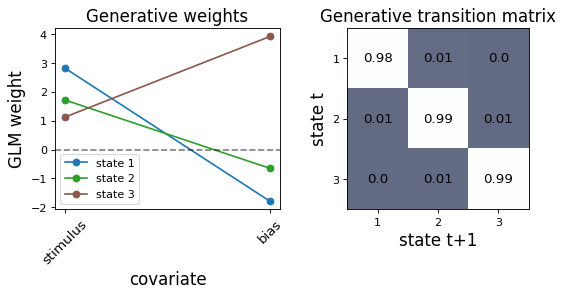

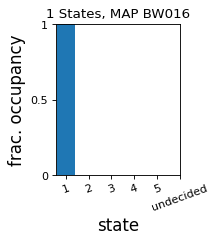

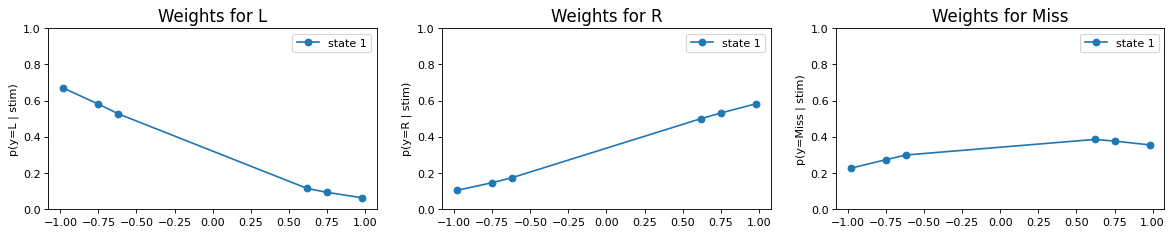

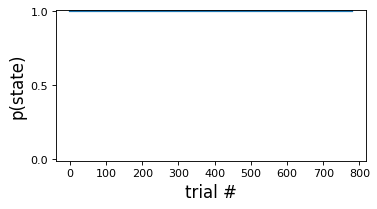

  0%|          | 0/2000 [00:00<?, ?it/s]

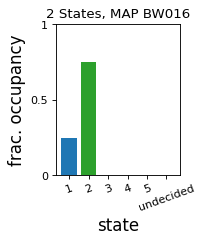

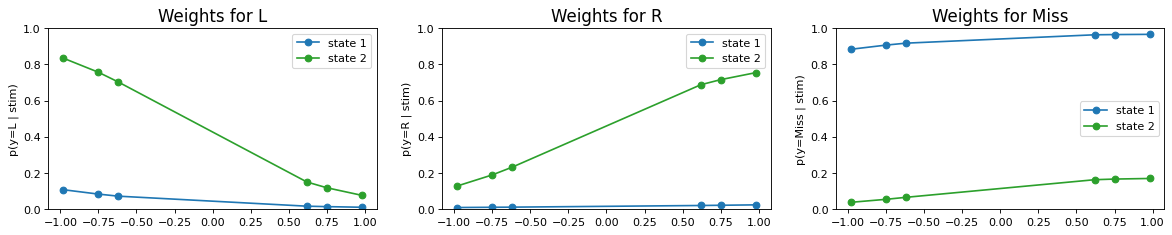

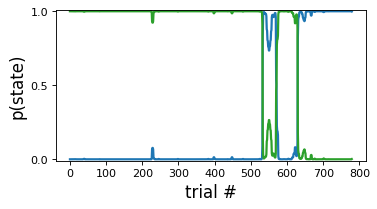

  0%|          | 0/2000 [00:00<?, ?it/s]

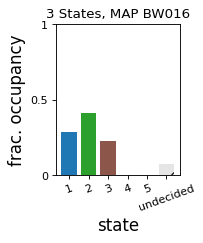

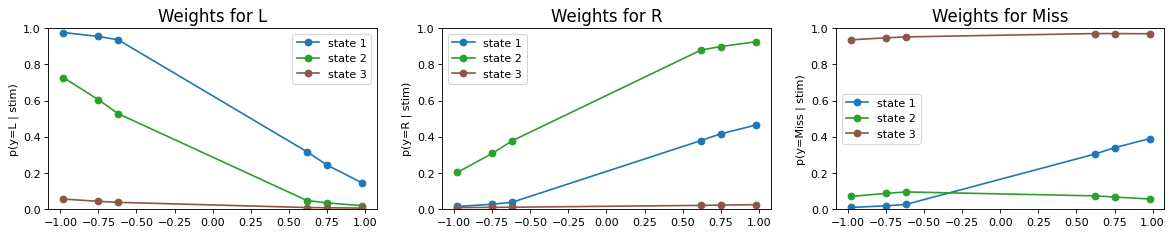

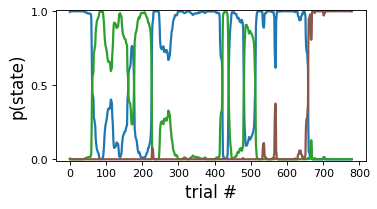

  0%|          | 0/2000 [00:00<?, ?it/s]

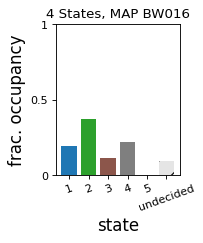

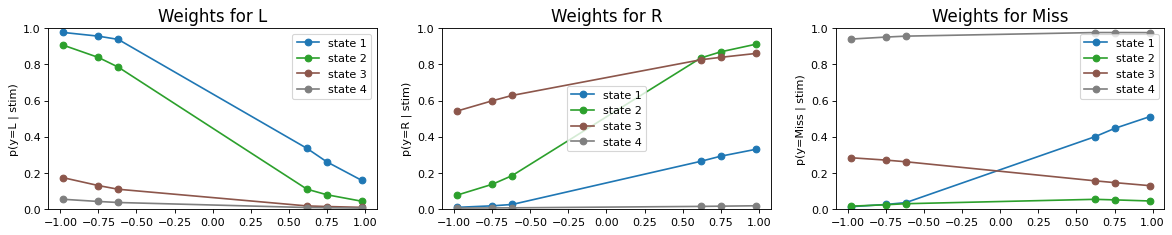

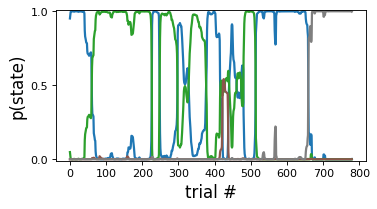

  0%|          | 0/2000 [00:00<?, ?it/s]

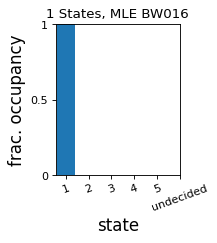

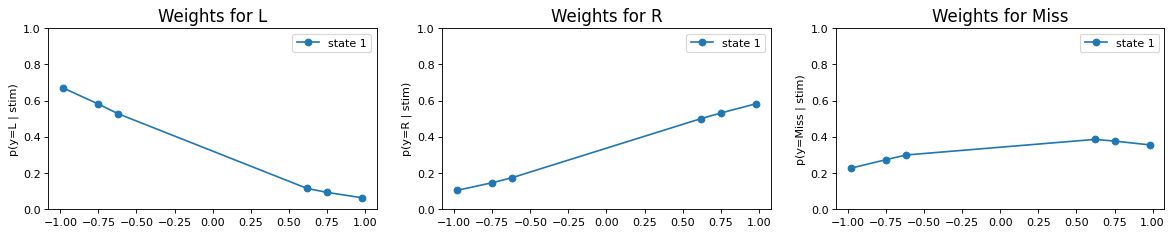

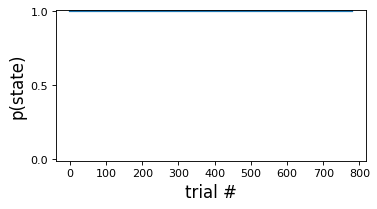

  0%|          | 0/2000 [00:00<?, ?it/s]

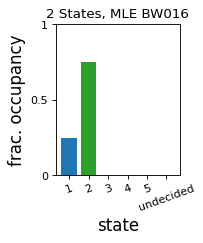

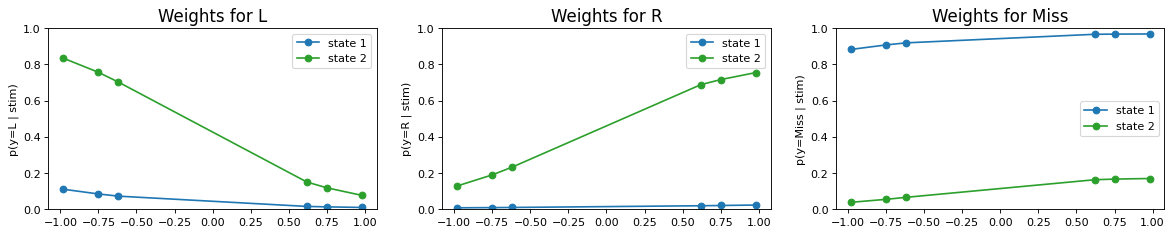

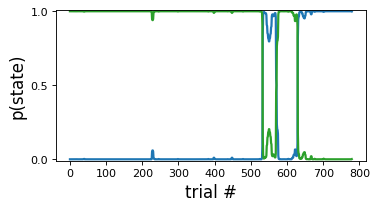

  0%|          | 0/2000 [00:00<?, ?it/s]

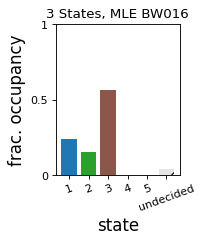

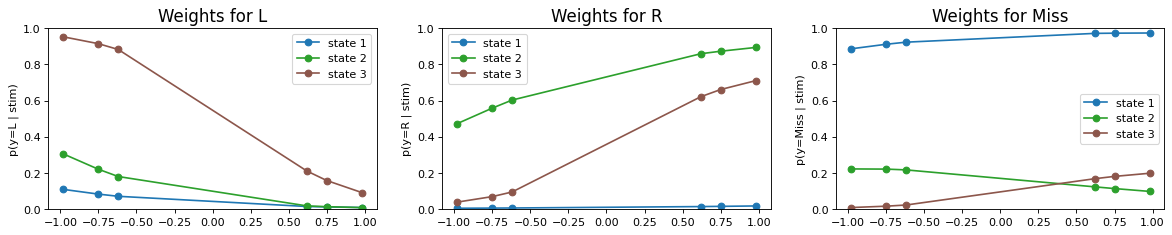

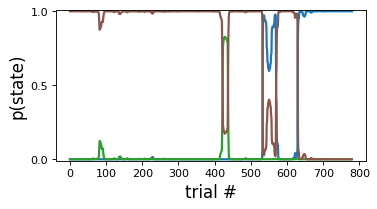

  0%|          | 0/2000 [00:00<?, ?it/s]

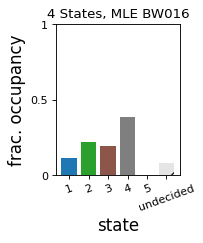

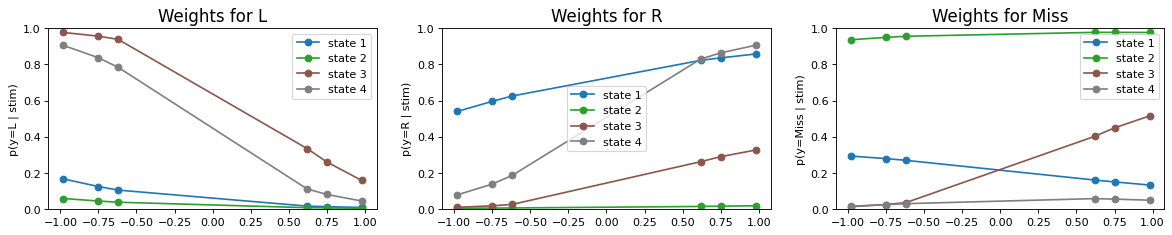

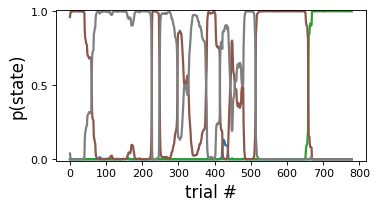

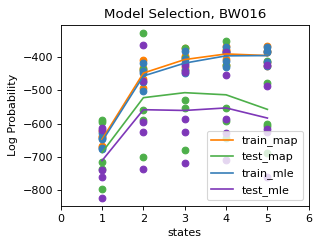

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

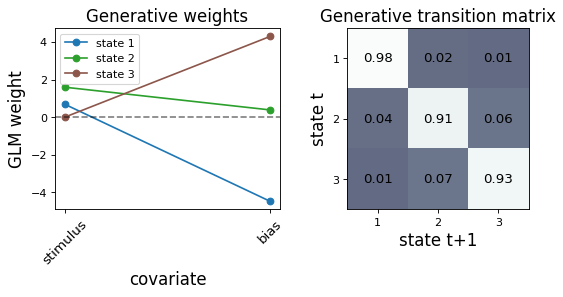

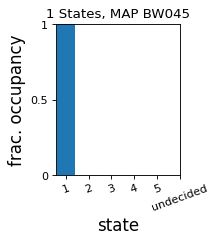

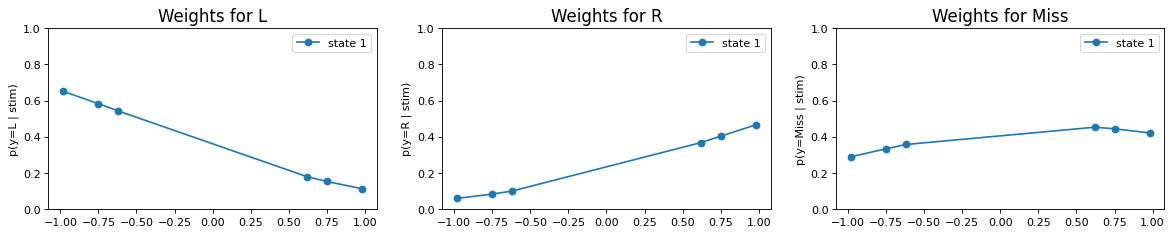

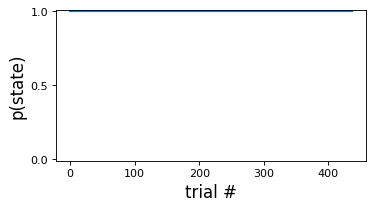

  0%|          | 0/2000 [00:00<?, ?it/s]

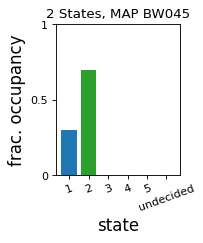

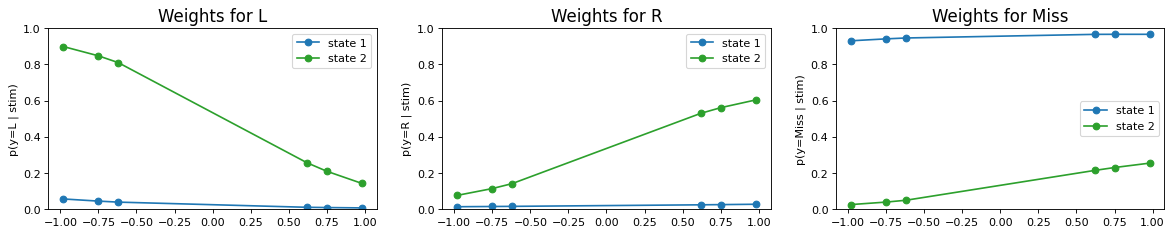

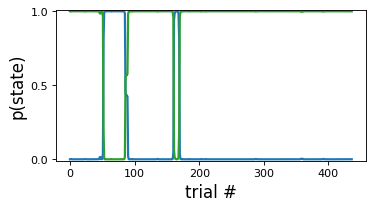

  0%|          | 0/2000 [00:00<?, ?it/s]

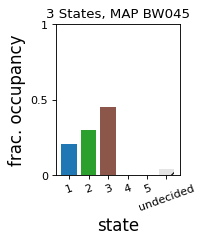

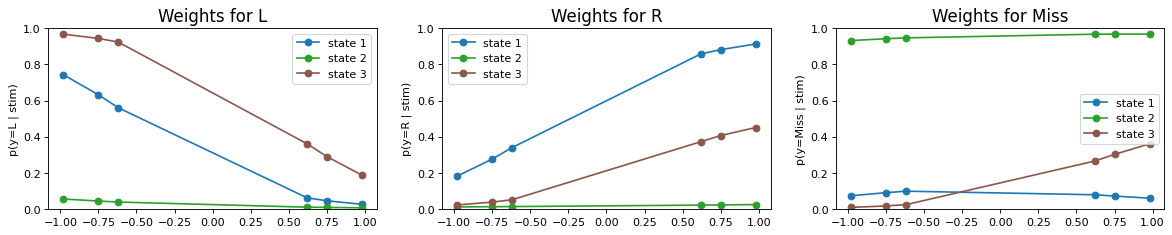

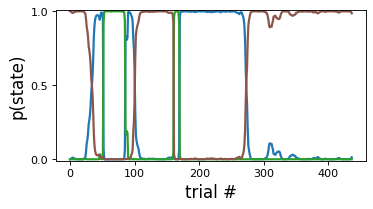

  0%|          | 0/2000 [00:00<?, ?it/s]

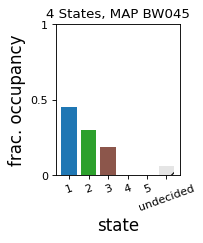

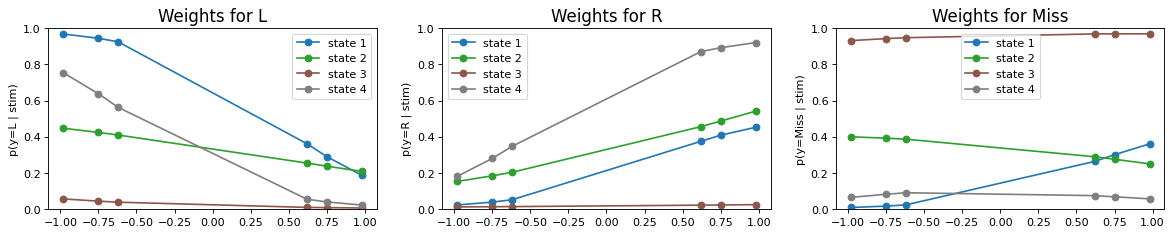

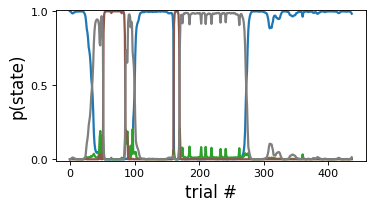

  0%|          | 0/2000 [00:00<?, ?it/s]

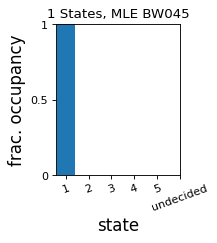

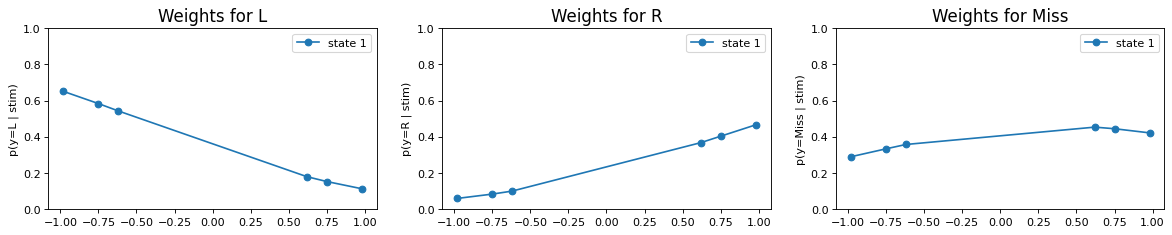

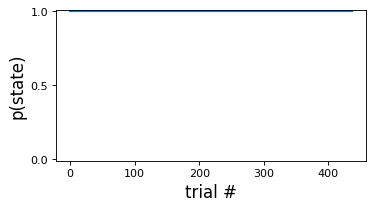

  0%|          | 0/2000 [00:00<?, ?it/s]

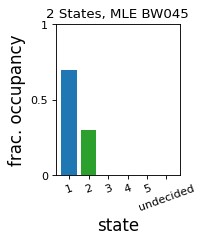

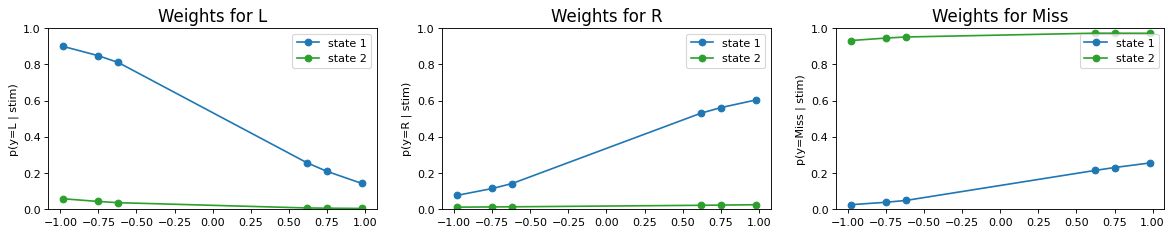

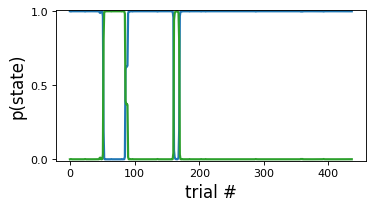

  0%|          | 0/2000 [00:00<?, ?it/s]

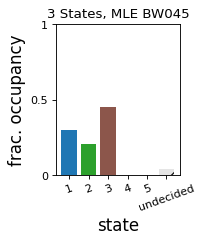

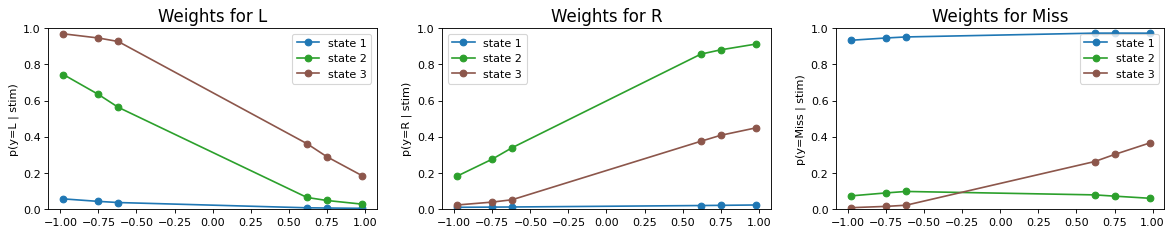

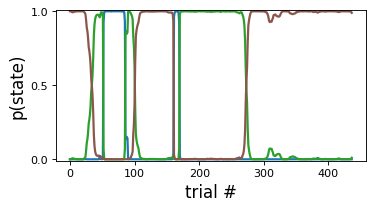

  0%|          | 0/2000 [00:00<?, ?it/s]

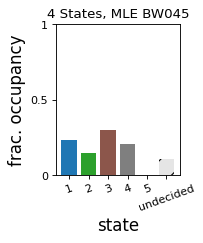

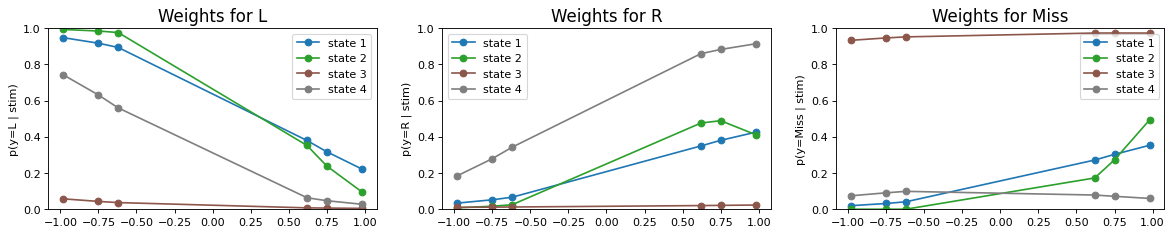

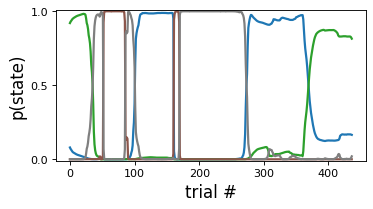

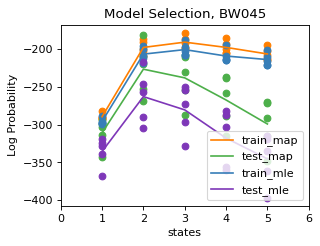

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
#create 10 ground truth models similar to mouse data
#dictionary of subject IDs and date ranges for mice in S5 training stage of 
#auditory task run by dhulsey
#
max_states = 5
min_states = 1
nKfold = 5
dhulsey_s5_aud = {'BW016': (20210421, 20210428),
                  'BW045': (20210909, 20210913)}
#'BW031': (20210910, 20210915), 'BW041': (20210901, 20210913),


model_dict = {}
param_dict = {}
for subject in dhulsey_s5_aud.keys():#for each mouse ID in dict of subjects fit a GLM-HMM
    ######Get the Data#######
    sessions=[]
    date_start = dhulsey_s5_aud[subject][0]
    date_end = dhulsey_s5_aud[subject][1]
    for fileID in range(date_start, date_end):
        this_session = load.get_file_path(subject,str(fileID))
        if this_session:
            sessions.append(this_session)

    inpts=list([])
    true_choices=list([])
    sessions_trial_start =list([])
    #sessions_response_inds = list([])
    for sess in sessions:
        trial_data, trial_labels = load.load_trial_data(sess)
        #print(sess + ' : ' + str(np.isnan(trial_data).any()))
        these_inpts, these_true_choices, trial_start = flex_hmm.format_all_behavior_hmm(trial_data, trial_labels)
        inpts.extend(these_inpts)
        true_choices.extend([these_true_choices])
        sessions_trial_start.extend([trial_start])
        #sessions_response_inds.extend([response_inds])
    
    stim_vals = [-.98,-.75,-.62,.62,.75,.98]
    ####Fit GLM-HMM
    # Set the parameters of the GLM-HMM
    num_states = 3        # number of discrete states
    obs_dim = 1           # number of observed dimensions
    num_categories = 3    # number of categories for output
    input_dim = 2         # input dimensions

    ###### Fit GLM-HMM with MAP estimation:
    # Instantiate GLM-HMM and set prior hyperparameters (MAP version)
    prior_sigma = 2
    prior_alpha = 2

    sub_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                         observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                         transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

    N_iters = 1000
    fit_sub_ll = sub_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters,
                                tolerance=10**-6)
    
    if subject == list(dhulsey_s5_aud.keys())[0]:#check if this is the first subject
        first_glmhmm = sub_glmhmm
    else:
        # Generate a sequence of latents and choices for each session
        true_latents, true_choices = [], []
        for sess in range(len(sessions)):
            num_trials_per_sess = len(inpts[sess])
            true_z, true_y = first_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
            true_latents.append(true_z)
            true_choices.append(true_y)
        
        sub_glmhmm.permute(find_permutation(np.hstack(true_latents), sub_glmhmm.most_likely_states(np.vstack(true_choices), input=np.vstack(inpts))))
    
    plotModelParams(sub_glmhmm, max_states)
    
    map_results, mle_results, models = modelSelectionCV(inpts, true_choices, max_states, nKfold, 
                                                    obs_dim, input_dim, N_iters=2000, 
                                                    TOL=10**-6, min_states=1)
    
    num_sess = len(sessions)
    map_mods, mle_mods = models[0], models[1]
    title = 'MAP ' + subject
    plotModelBehavCV(inpts, true_choices, stim_vals,
                     max_states, min_states, num_categories, obs_dim, 
                     input_dim, 'MAP', title)
    title = 'MLE ' + subject
    plotModelBehavCV(inpts, true_choices, stim_vals,
                     max_states, min_states, num_categories, obs_dim, 
                     input_dim, 'MLE', title)
    
    #plot results
    training_results_map = map_results[0]
    testing_results_map = map_results[1]
    training_results_mle = mle_results[0]
    testing_results_mle = mle_results[1]

    cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
    fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
    for iS, num_states in enumerate(range(1,max_states+1)):
        plt.plot((iS+1)*np.ones(nKfold),training_results_map[iS,:], color=cols[0], marker='o',lw=0)
        plt.plot((iS+1)*np.ones(nKfold),testing_results_map[iS,:], color=cols[1], marker='o',lw=0)

        plt.plot((iS+1)*np.ones(nKfold),training_results_mle[iS,:], color=cols[2], marker='o',lw=0)
        plt.plot((iS+1)*np.ones(nKfold),testing_results_mle[iS,:], color=cols[3], marker='o',lw=0)

    plt.plot(range(1,max_states+1),np.mean(training_results_map,1), label="train_map", color=cols[0])
    plt.plot(range(1,max_states+1),np.mean(testing_results_map,1), label="test_map", color=cols[1])

    plt.plot(range(1,max_states+1),np.mean(training_results_mle,1), label="train_mle", color=cols[2])
    plt.plot(range(1,max_states+1),np.mean(testing_results_mle,1), label="test_mle", color=cols[3])

    # plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
    plt.title('Model Selection, ' + subject)
    plt.legend(loc="lower right")
    plt.xlabel("states")
    plt.xlim(0, max_states+1)
    plt.ylabel("Log Probability")
    plt.show()
    
    
    # NOTE: EM algorithm is not convex ie you find a different result every time you run it
    # To deal with this issue, we will run EM 5 times on all the data but with random initial conditions and pick the best run 
    # pick the state with the best MAP likelihood and retrain the model on the whole dataset      
    #best_map=np.mean(testing_results_map,1).argmax()
    num_states_map=3#best_map+1
    #Create HMM object to fit: MAP
    # Instantiate GLM-HMM and set prior hyperparameters
    prior_sigma = 2
    prior_alpha = 2
    map_glmhmm = ssm.HMM(num_states_map, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                 transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
    # fit on whole data
    Nruns=5
    ll_runs=np.zeros((Nruns))
    hmm_runs=[]
    nData = len(inpts)
    for iRun in range(Nruns):
        map_glmhmm = ssm.HMM(num_states_map, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                 transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
        hmm_lls = map_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-6)                
        hmm_runs.append(map_glmhmm)
        ll_runs[iRun] = map_glmhmm.log_probability(true_choices, inputs=inpts)/nData
        
    best_run=ll_runs.argmax()
    hmm_bestfit=hmm_runs[best_run]

    model_dict[subject] = hmm_bestfit#add GLM-HMM model to dictionary of all fit GLM-HMMs
    param_dict[subject] = {'GLM_weights': hmm_bestfit.observations.params, 
                           'HMM_probs': hmm_bestfit.transitions.log_Ps}
    #data_dict[subject] = 'auditory_stim_difficulty'



Plot generative model parameters:

Text(0.5, 1.0, 'Generative transition matrix')

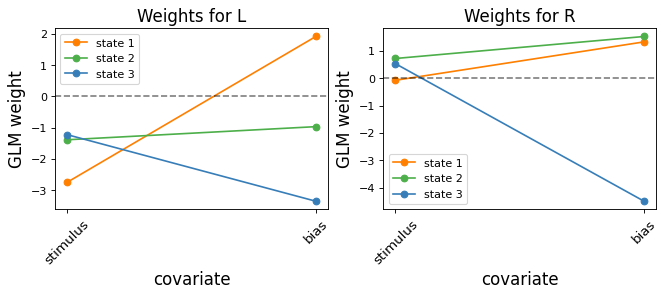

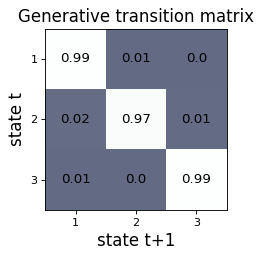

In [107]:
# Plot generative parameters:
name_categories=['L','R','miss'] # name of the categories: left, miss, right
subject = 'BW016'
true_glmhmm = model_dict[subject]
gen_weights = true_glmhmm.observations.params
gen_log_trans_mat = true_glmhmm.transitions.params
num_states = gen_log_trans_mat[0].shape[0]
fig = plt.subplots(1, gen_weights.shape[1], sharey='all', figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
# fig = plt.figure(figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
for iC in range(gen_weights.shape[1]):
    plt.subplot(1, gen_weights.shape[1]+1, iC+1)
    for k in range(num_states):
        plt.plot(range(input_dim), gen_weights[k][iC], marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="state " + str(k+1))
    plt.yticks(fontsize=10)
    plt.ylabel("GLM weight", fontsize=15)
    plt.xlabel("covariate", fontsize=15)
    plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
    plt.axhline(y=0, color="k", alpha=0.5, ls="--")
    plt.legend()
    plt.title('Weights for {}'.format(name_categories[iC]), fontsize = 15)


fig = plt.figure(figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

In [108]:
gen_weights.shape

(3, 2, 2)

0
1
2
3


IndexError: index 3 is out of bounds for axis 0 with size 3

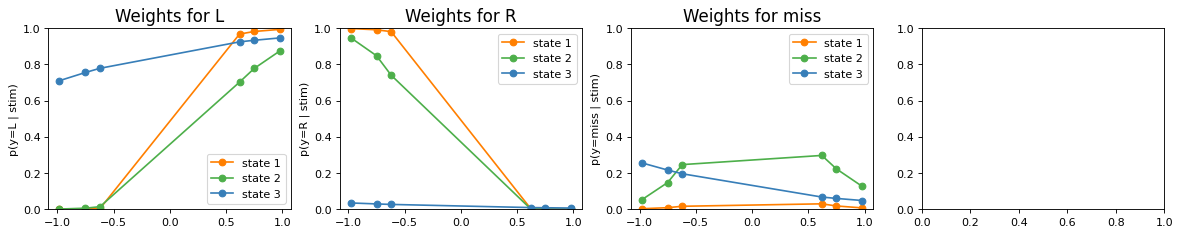

In [113]:
# Plot generative parameters:
#stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
stim_vals = [-.98,-.75,-.62,.62,.75,.98]
fig = plt.subplots(1, gen_weights.shape[1], sharey='all', figsize=(18, 3), dpi=80, facecolor='w', edgecolor='k')
# fig = plt.figure(figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
for iC in range(gen_weights.shape[1]+1):
    plt.subplot(1, gen_weights.shape[1]+1, iC+1)
    for k in range(num_states):
        psycho_out=psychometrics(gen_weights[k],stim_vals)
        plt.plot(stim_vals, psycho_out[iC], marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="state " + str(k+1))
    plt.yticks(fontsize=10)
    plt.ylim((0.0, 1.0))
    plt.ylabel('p(y={} | stim)'.format(name_categories[iC]), fontsize=10)
    plt.legend()
    plt.title('Weights for {}'.format(name_categories[iC]), fontsize = 15)

3


ValueError: 'a' and 'p' must have same size

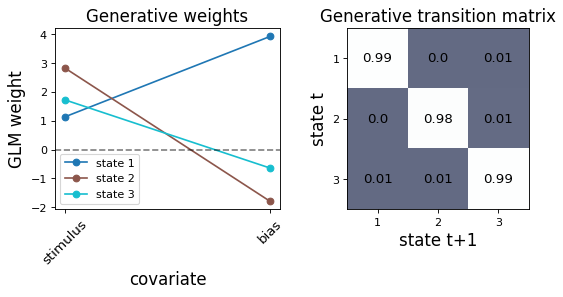

In [145]:
#do model selection on Ashwood mouse example and fit back with fewer and fewer stimuli.
#define model
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 3    # number of categories for output
input_dim = 2         # input dimensions
subjects = {'BW016': param_dict['BW016']}
sub = 'BW016'
#use the model parameters defined by Ashwood et al
# gen_weights = np.array([[[4, 1],[-5, 1]], [[3, -1],[-5, -2]], [[1, 2],[0, -2]]])
# gen_log_trans_mat = np.log(np.array([[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.02, 0.03, 0.94]]))
# ash_params = {'Test': {'GLM_weights': gen_weights, 
#                        'HMM_probs': gen_log_trans_mat}}
# sub = 'Test'
#Model Selection params
#loop over many different sesion counts and plot L2 distance between the generative model
#parameters and the recovered parameters
num_sess_max = 20
nKfold = 5# np.min([num_sess,5]) # if there are more than 4 sessions, group sessions together to create 4 folds
max_states = 5 # largest number of states allowed in the model selection
min_states = 1
num_sess_min = 1#minimum number of sessions to test
num_trials_per_sess = 400


stim_vals_test = [[-.98,-.75,-.62,.62,.75,.98],
                [-.98 , -0.5,  0. ,  0.5,  .98 ],
                [-.98 , -0.4,  0.4,  .98],
                [-.98 , -0.125,  .98  ]]

n_stims = len(stim_vals_test)
#create array to hold training results for all ground truth models, MAP
training_results_map = np.empty((n_stims, num_sess_max-num_sess_min, max_states, nKfold))
#create array to hold testing results for all ground truth models, MAP
testing_results_map = np.empty((n_stims, num_sess_max-num_sess_min, max_states, nKfold))

#create array to hold training results for all ground truth models, MLE
training_results_mle = np.empty((n_stims, num_sess_max-num_sess_min, max_states, nKfold))
#create array to hold testing results for all ground truth models, MLE
testing_results_mle = np.empty((n_stims, num_sess_max-num_sess_min, max_states, nKfold))

#array to hold BIC results
BIC_results = np.empty((n_stims, num_sess_max-num_sess_min, max_states))
#for each ground stim set.. see how many sessions it takes to recover params
for i, stim_vals in enumerate(stim_vals_test):
    true_glmhmm = makeModel(num_states, obs_dim, num_categories, input_dim,
                                   subjects[sub])
    inpts, true_latents, true_choices = simulateData(true_glmhmm, num_sess_max, 
                                                 num_trials_per_sess, stim_vals)
    data_sim = [inpts, true_latents, true_choices]
    map_, mle_, BIC_ = modelSelection(data_sim, num_states, obs_dim, num_categories, 
                                      input_dim, num_sess_min, num_sess_max, num_trials_per_sess, 
                                      stim_vals, nKfold, max_states, min_states, plot=True)
    training_results_map[i, :, :, :] = map_[0]
    testing_results_map[i, :, :, :] = map_[1]
    training_results_mle[i, :, :, :] = mle_[0]
    testing_results_mle[i, :, :, :] = mle_[1]
            
    BIC_results[i, :, :] = BIC_
    

    

In [127]:
for j, stim_vals in enumerate(stim_vals_test):
    for i in range(training_results_map.shape[1]):#for each tested session length
        train_map = training_results_map[j,i,:,:]
        test_map = testing_results_map[j,i,:,:]

        train_mle = training_results_mle[j,i,:,:]
        test_mle = testing_results_mle[j,i,:,:]

        cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
        fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
        for iS, num_states in enumerate(range(1,max_states+1)):
            plt.plot((iS+1)*np.ones(nKfold),train_map[iS,:], color=cols[0], marker='o',lw=0)
            plt.plot((iS+1)*np.ones(nKfold),test_map[iS,:], color=cols[1], marker='o',lw=0)

            plt.plot((iS+1)*np.ones(nKfold),train_mle[iS,:], color=cols[2], marker='o',lw=0)
            plt.plot((iS+1)*np.ones(nKfold),test_mle[iS,:], color=cols[3], marker='o',lw=0)

        plt.plot(range(1,max_states+1),np.mean(train_map,1), label="train_map", color=cols[0])
        plt.plot(range(1,max_states+1),np.mean(test_map,1), label="test_map", color=cols[1])

        plt.plot(range(1,max_states+1),np.mean(train_mle,1), label="train_mle", color=cols[2])
        plt.plot(range(1,max_states+1),np.mean(test_mle,1), label="test_mle", color=cols[3])

        # plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
        plt.title(sub + ' Model Selection, ' + str(i + 1) + ' Sessions')
        plt.legend(loc="lower right")
        plt.xlabel("states")
        plt.xlim(0, max_states+1)
        plt.ylabel("Log Probability")
        plt.show()

IndentationError: unexpected indent (<ipython-input-127-4f9c9ef4f679>, line 9)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

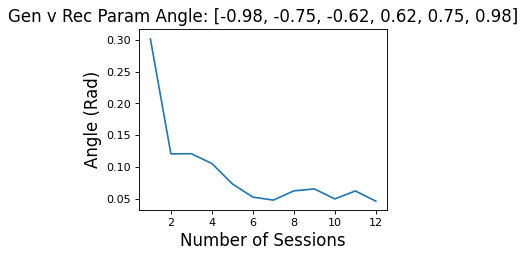

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

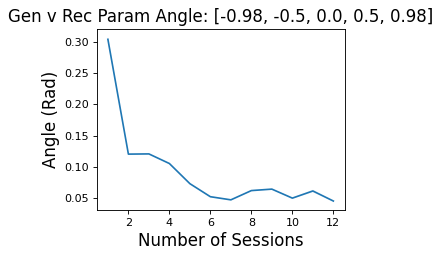

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

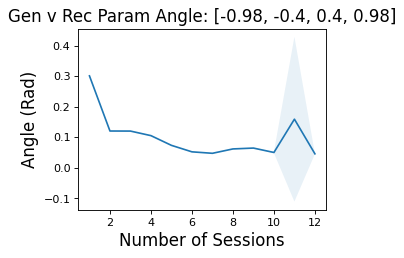

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

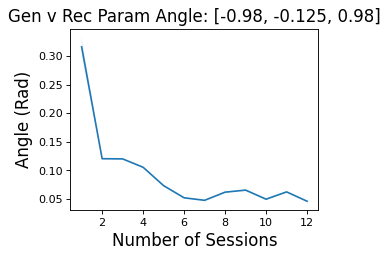

In [142]:
#loop over many different sesion counts and plot L2 distance between the generative model
#parameters and the recovered parameters
num_sess_max = 13
nKfold = 5# np.min([num_sess,5]) # if there are more than 4 sessions, group sessions together to create 4 folds
max_states = 5 # largest number of states allowed in the model selection
min_states = 1
num_sess_min = 1#minimum number of sessions to test
num_trials_per_sess = 400

# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states for ground truth model
obs_dim = 1           # number of observed dimensions for ground truth model
num_categories = 3    # number of categories for output for ground truth model
input_dim = 2         # input dimensions for ground truth model
subjects = {'BW016': param_dict['BW016']}#available 'BW016','BW031', 'BW045'
sub = 'BW016'
angles = []
iters = 5
#for each ground stim set.. see how many sessions it takes to recover params
for i, stim_vals in enumerate(stim_vals_test):
    angles = []
    for j in range(iters):
        true_glmhmm = makeModel(num_states, obs_dim, num_categories, input_dim,
                                       subjects[sub], plot=False)
        inpts, true_latents, true_choices = simulateData(true_glmhmm, num_sess_max, 
                                                         num_trials_per_sess, stim_vals,
                                                         plot=False)
        subject_angles = paramRecovery(data_sim, num_states, obs_dim, num_categories, input_dim,
                          num_sess_min, num_sess_max)
        angles.append(subject_angles)

    start = num_sess_min
    max_range = num_sess_max
    angles = np.vstack(angles)
    fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
    angle_av = np.mean(angles, axis=0)#calculate average angle for each session number                                                                                                                                                 
    se = stats.sem(angles, axis=0)#calculate standard error                                                                                                                                                                                     
    n = angles.shape[0]                                                                                                                                                                                                       
    confidence=0.95                                                                                                                                                                                                           
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)                                                                                                                                                                          
    angle_top = angle_av + h#find max loss value for each epoch                                                                                                                                                                     
    angle_bottom = angle_av - h#find minimum loss value for each epoch                                                                                                                                                                                                                                                                                                                                              
    plt.fill_between(range(start, max_range), (angle_bottom), (angle_top), alpha=.1)  
    plt.plot(range(start, max_range), angle_av)
    plt.yticks(fontsize=10)
    plt.ylabel("Angle (Rad)", fontsize=15)
    plt.xlabel("Number of Sessions", fontsize=15)
    plt.title("Gen v Rec Param Angle: " + str(stim_vals), fontsize=15)
    plt.show()

In [14]:
param_dict['BW016']['GLM_weights'].shape

(4, 2, 2)

In [101]:
#Bootstrap sample the parameter distributions
# grnd_truth_N = 10
# flat_param_arrays = []
# for subject in param_dict.keys():
#     subject_params = []
#     for param_type in param_dict[subject].keys():
#         param_array = param_dict[subject][param_type]
#         param_array_flat = param_dict[subject][param_type].flatten()
#         subject_params.append(param_array_flat)
#     subject_params = np.hstack(subject_params)
#     flat_param_arrays.append(subject_params)

# subject_params = np.stack(flat_param_arrays)
# dist_assump = 'uniform'#could also be uniform
# new_params = np.empty((grnd_truth_N, subject_params.shape[1]))
# for i in range(subject_params.shape[1]):
#     p_dat = subject_params[:,i]
#     if dist_assump == 'normal':
#         p_dat_new = np.random.normal(loc=np.mean(p_dat), scale=np.std(p_dat), size=grnd_truth_N-len(param_dict.keys()))
#     elif dist_assump == 'uniform':
#         min_i = np.argmin(p_dat)
#         max_i = np.argmax(p_dat)
#         p_dat_new = np.random.uniform(low=p_dat[min_i], high=p_dat[max_i], size=grnd_truth_N-len(param_dict.keys()))
#     #concatenate experimental params and resampled params together
#     new_params[:,i] = np.append(p_dat, p_dat_new)

In [33]:
#MODEL SELECTION
#loop over many different sesion counts and plot L2 distance between the generative model
#parameters and the recovered parameters
num_sess_max = 20
nKfold = 5# np.min([num_sess,5]) # if there are more than 4 sessions, group sessions together to create 4 folds
max_states = 5 # largest number of states allowed in the model selection
min_states = 1
num_sess_min = 1#minimum number of sessions to test
num_trials_per_sess = 400

# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states for ground truth model
obs_dim = 1           # number of observed dimensions for ground truth model
num_categories = 3    # number of categories for output for ground truth model
input_dim = 2         # input dimensions for ground truth model
stim_vals = [-.98,-.75,-.62,.62,.75,.98] #stimuli to use for generating synthetic data from ground truth model
#subjects = {'BW016': param_dict['BW016']}#available 'BW016','BW031', 'BW045'
subjects = param_dict
n_subs = len(subjects.keys())#number of subjects included in original, real data

#create array to hold training results for all ground truth models, MAP
training_results_map = np.empty((n_subs, num_sess_max-num_sess_min, max_states, nKfold))
#create array to hold testing results for all ground truth models, MAP
testing_results_map = np.empty((n_subs, num_sess_max-num_sess_min, max_states, nKfold))

#create array to hold training results for all ground truth models, MLE
training_results_mle = np.empty((n_subs, num_sess_max-num_sess_min, max_states, nKfold))
#create array to hold testing results for all ground truth models, MLE
testing_results_mle = np.empty((n_subs, num_sess_max-num_sess_min, max_states, nKfold))

#array to hold BIC results
BIC_results = np.empty((n_subs, num_sess_max-num_sess_min, max_states))
#for each ground truth parameter set.. see how many sessions it takes to recover params
######SEPERATE OUT DATA GEN AND FIT######
nIters = 10#how many times to model select for a given mouse
sessions_to_recover_subs = []
for i, sub in enumerate(subjects.keys()):
    sessions_to_recover = []
    for itr in range(nIters):
        true_glmhmm = makeModel(num_states, obs_dim, num_categories, input_dim,
                                       subjects[sub], plot=False)
        inpts, true_latents, true_choices = simulateData(true_glmhmm, num_sess_max, 
                                                     num_trials_per_sess, stim_vals, plot=False)
        data_sim = [inpts, true_latents, true_choices]
        map_, mle_, BIC_, sess_to_recov = modelSelection(data_sim, num_states, obs_dim, num_categories, 
                                          input_dim, num_sess_min, num_sess_max, num_trials_per_sess, 
                                          stim_vals, nKfold, max_states, min_states, plot=False)
        training_results_map[i, :, :, :] = map_[0]
        testing_results_map[i, :, :, :] = map_[1]
        training_results_mle[i, :, :, :] = mle_[0]
        testing_results_mle[i, :, :, :] = mle_[1]

        BIC_results[i, :, :] = BIC_
        
        sessions_to_recover.append(sess_to_recov)
    sessions_to_recover_subs.append(np.array(sessions_to_recover))
#synthetic data: list of length num sess, elements are trial num x obs_dim (1)
#synthetic inpts: list of length num sess, elements are trial num x input_dim (2)
#training data: list of length training folds (4), elements are trial num x obs_dim (1)
#training inpts: list of length training folds (4), elements are trial num x input_dim (2)




In [34]:
sessions_to_recover_subs

[array([6, 6, 5, 3, 5, 6, 8, 5, 2, 2]),
 array([11,  7,  8, 11, 12,  5,  9, 11,  9, 11])]

In [116]:
#plot results
for j, sub in enumerate(subjects.keys()):
    for i in range(training_results_map.shape[1]):#for each tested session length
        train_map = training_results_map[j,i,:,:]
        test_map = testing_results_map[j,i,:,:]

        train_mle = training_results_mle[j,i,:,:]
        test_mle = testing_results_mle[j,i,:,:]

        cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
        fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
        for iS, num_states in enumerate(range(1,max_states+1)):
            plt.plot((iS+1)*np.ones(nKfold),train_map[iS,:], color=cols[0], marker='o',lw=0)
            plt.plot((iS+1)*np.ones(nKfold),test_map[iS,:], color=cols[1], marker='o',lw=0)

            plt.plot((iS+1)*np.ones(nKfold),train_mle[iS,:], color=cols[2], marker='o',lw=0)
            plt.plot((iS+1)*np.ones(nKfold),test_mle[iS,:], color=cols[3], marker='o',lw=0)

        plt.plot(range(1,max_states+1),np.mean(train_map,1), label="train_map", color=cols[0])
        plt.plot(range(1,max_states+1),np.mean(test_map,1), label="test_map", color=cols[1])

        plt.plot(range(1,max_states+1),np.mean(train_mle,1), label="train_mle", color=cols[2])
        plt.plot(range(1,max_states+1),np.mean(test_mle,1), label="test_mle", color=cols[3])

        # plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
        plt.title(sub + ' Model Selection, ' + str(i + 1) + ' Sessions')
        plt.legend(loc="lower right")
        plt.xlabel("states")
        plt.xlim(0, max_states+1)
        plt.ylabel("Log Probability")
        plt.show()

NameError: name 'subjects' is not defined

<Figure size 320x240 with 0 Axes>

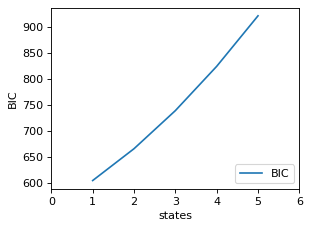

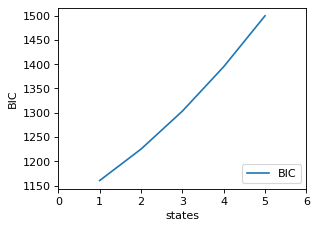

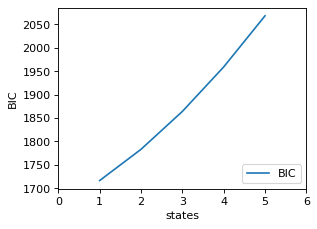

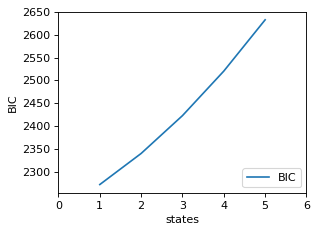

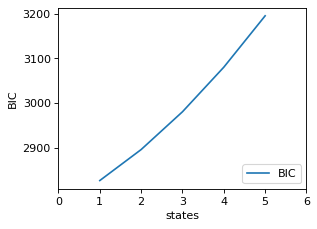

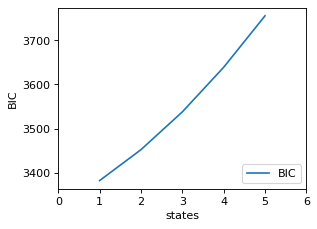

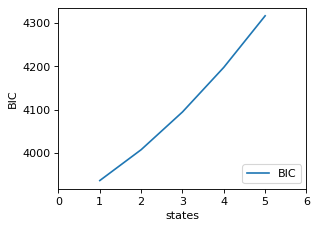

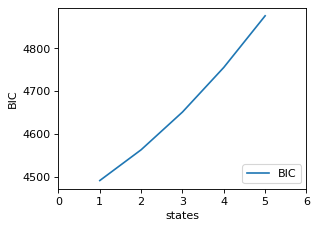

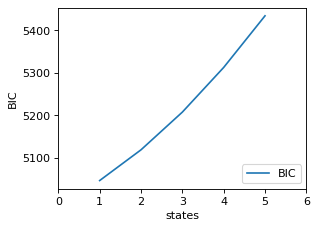

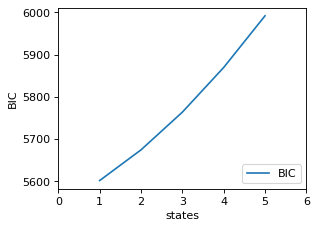

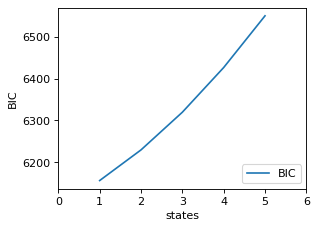

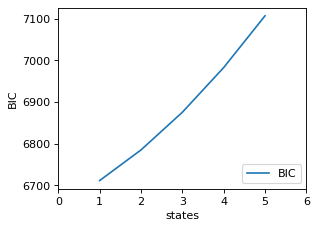

In [80]:
#plot results
subjects = BIC_results.shape[0]
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
for i in range(BIC_results.shape[1]):#for each tested session length
    BIC_av = np.mean(BIC_results[:, i, :], axis=0)#calculate average train results for each ground truth
    
#     for sub in range(subjects):
#         for iS, num_states in enumerate(range(1,max_states+1)):
#             plt.plot((iS+1)*np.ones(subjects),BIC_results[sub, iS,:], color=cols[0], marker='o',lw=0)

    fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(range(1,max_states+1),BIC_av, label="BIC")
    plt.legend(loc="lower right")
    plt.xlabel("states")
    plt.xlim(0, max_states+1)
    plt.ylabel("BIC")
    plt.show()

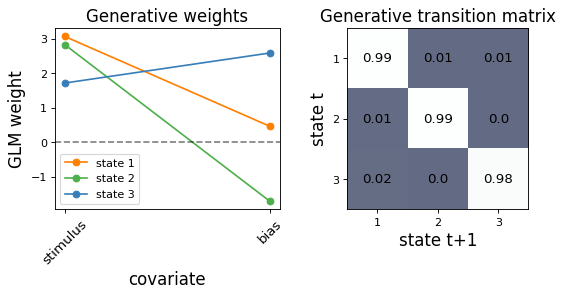

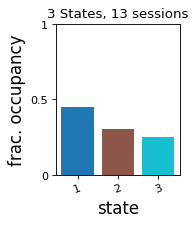

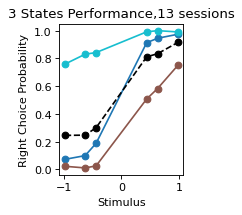

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Text(0.5, 1.0, 'Generative vs Recovered Parameters Angle')

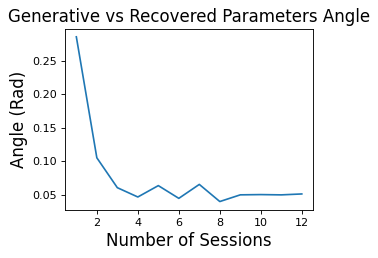

In [74]:
#loop over many different sesion counts and plot L2 distance between the generative model
#parameters and the recovered parameters
num_sess_max = 13
nKfold = 5# np.min([num_sess,5]) # if there are more than 4 sessions, group sessions together to create 4 folds
max_states = 5 # largest number of states allowed in the model selection
min_states = 1
num_sess_min = 1#minimum number of sessions to test
num_trials_per_sess = 400

# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states for ground truth model
obs_dim = 1           # number of observed dimensions for ground truth model
num_categories = 2    # number of categories for output for ground truth model
input_dim = 2         # input dimensions for ground truth model
stim_vals = [-.98,-.75,-.62,.62,.75,.98] #stimuli to use for generating synthetic data from ground truth model
subjects = {'BW016': param_dict['BW016']}#available 'BW016','BW031', 'BW045'
#subjects = param_dict
n_subs = len(subjects.keys())#number of subjects included in original, real data
angles = []
for i, sub in enumerate(subjects.keys()):
    true_glmhmm = makeModel(num_states, obs_dim, num_categories, input_dim,
                                   subjects[sub])
    inpts, true_latents, true_choices = simulateData(true_glmhmm, num_sess_max, 
                                                 num_trials_per_sess, stim_vals)
    subject_angles = paramRecovery(data_sim, num_states, obs_dim, num_categories, input_dim,
                      num_sess_min, num_sess_max)
    angles.append(subject_angles)

start = num_sess_min
max_range = num_sess_max
angles = np.vstack(angles)
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
angle_av = np.mean(angles, axis=0)#calculate average angle for each session number                                                                                                                                                 
se = stats.sem(angles, axis=0)#calculate standard error                                                                                                                                                                                     
n = angles.shape[0]                                                                                                                                                                                                       
confidence=0.95                                                                                                                                                                                                           
h = se * stats.t.ppf((1 + confidence) / 2., n-1)                                                                                                                                                                          
angle_top = angle_av + h#find max loss value for each epoch                                                                                                                                                                     
angle_bottom = angle_av - h#find minimum loss value for each epoch                                                                                                                                                                                                                                                                                                                                              
plt.fill_between(range(start, max_range), (angle_bottom), (angle_top), alpha=.1)  
plt.plot(range(start, max_range), angle_av)
plt.yticks(fontsize=10)
plt.ylabel("Angle (Rad)", fontsize=15)
plt.xlabel("Number of Sessions", fontsize=15)
plt.title("Generative vs Recovered Parameters Angle", fontsize=15)

In [25]:
#get model data
subject='BW016'
sessions=[]
for fileID in range(20210421,20210428):
    this_session = load.get_file_path(subject,str(fileID))
    if this_session:
        sessions.append(this_session)

inpts=list([])
true_choices=list([])
sessions_trial_start =list([])
#sessions_response_inds = list([])
for sess in sessions:
    trial_data, trial_labels = load.load_trial_data(sess)
    these_inpts, these_true_choices, trial_start, response_inds = flex_hmm.format_all_behavior_hmm(trial_data, trial_labels)
    inpts.extend(these_inpts)
    true_choices.extend([these_true_choices])
    sessions_trial_start.extend([trial_start])
    #sessions_response_inds.extend([response_inds])

/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/hdmf/spec/namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/Users/danielburnham/opt/anaconda3/envs/uobrainflex/lib/python3.6/site-packages/hdmf/spec/namespace.py:533: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


In [26]:
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

###### Fit GLM-HMM with MAP estimation:
# Instantiate GLM-HMM and set prior hyperparameters (MAP version)
prior_sigma = 2
prior_alpha = 2

map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                     observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                     transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

N_iters = 200
fit_map_ll = map_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters,
                            tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Generative transition matrix')

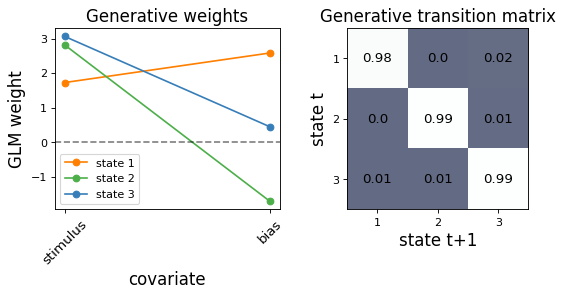

In [27]:
# Plot generative parameters:
params = map_glmhmm.observations.params
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#7E37B8']
for k in range(num_states):
    plt.plot(range(input_dim), params[k,:][0]*-1, marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

In [6]:
#Simulate an example set of external inputs for each trial in a session.
num_sess = 10 # number of example sessions
num_trials_per_sess = 500 # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = [-.98,-.75,-.62,.62,.75,.98]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct format

In [7]:
# Generate a sequence of latents and choices for each session
true_latents, true_choices = [], []
for sess in range(num_sess):
    true_z, true_y = map_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)
    
# Calculate true loglikelihood
true_ll = map_glmhmm.log_probability(true_choices, inputs=inpts) 
print("true ll = " + str(true_ll))

true ll = -1872.052261333552


In [8]:
#instantiate a new GLM-HMM
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                     observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                     transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

#it new GLM-HMM with MAP estimation:
N_iters = 200
new_fit_map_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters,
                            tolerance=10**-4)

#first need to permute the states of the fit GLM-HMM relative to the generative model.
new_glmhmm.permute(find_permutation(true_latents[0], new_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

  0%|          | 0/200 [00:00<?, ?it/s]

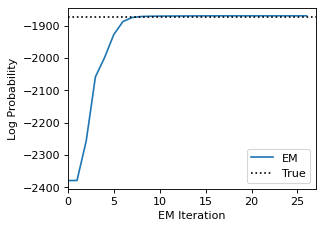

In [9]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(new_fit_map_ll, label="EM")
plt.plot([0, len(new_fit_map_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(new_fit_map_ll))
plt.ylabel("Log Probability")
plt.show()

Text(0.5, 1.0, 'Weight recovery')

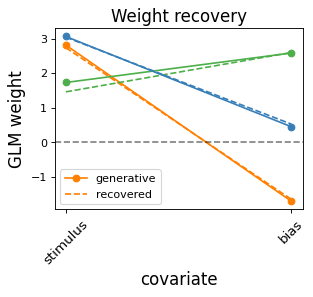

In [10]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0:
        plt.plot(range(input_dim), params[k,:][0]*-1, marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k,:][0]*-1, color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
        plt.plot(range(input_dim), params[k,:][0]*-1, marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k,:][0]*-1, color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')

plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

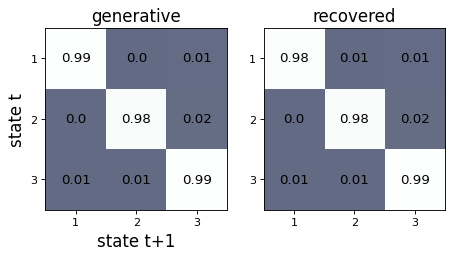

In [11]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("generative", fontsize = 15)


plt.subplot(1, 2, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Generative vs Recovered Parameters Angle')

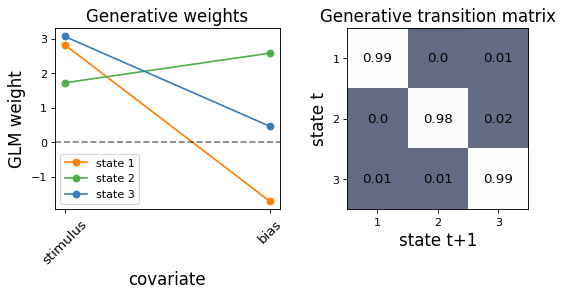

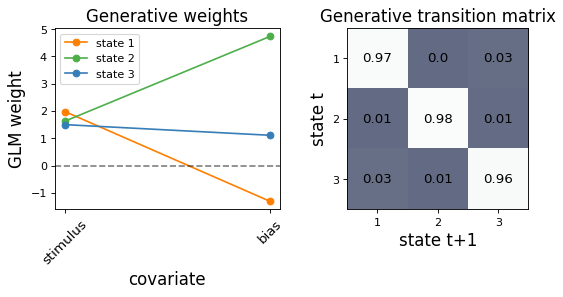

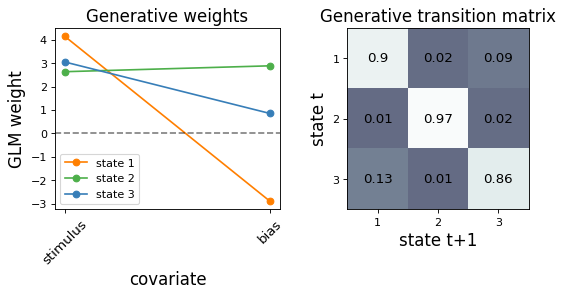

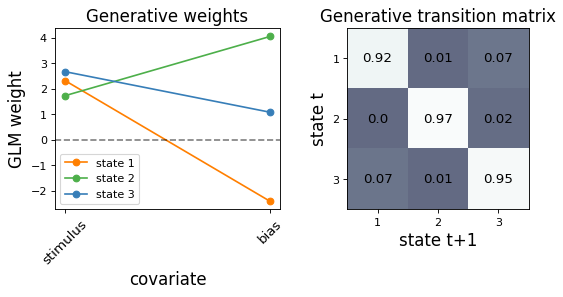

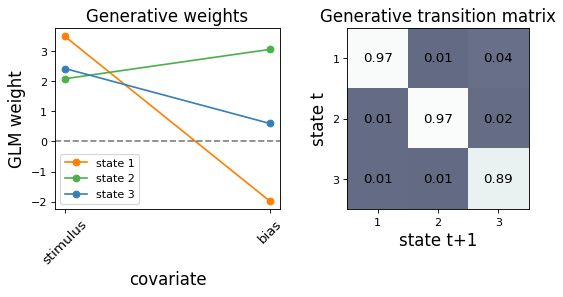

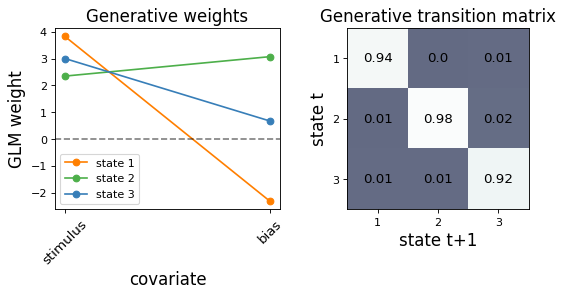

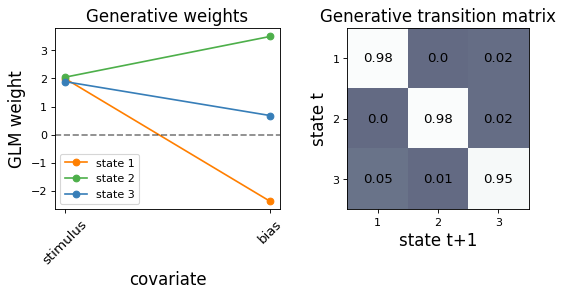

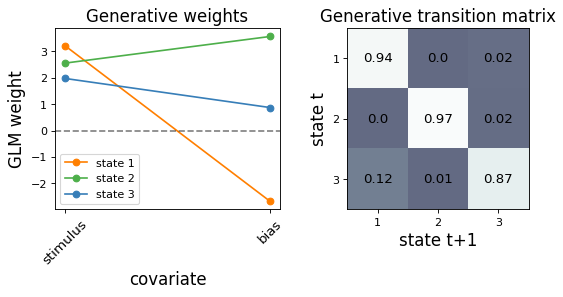

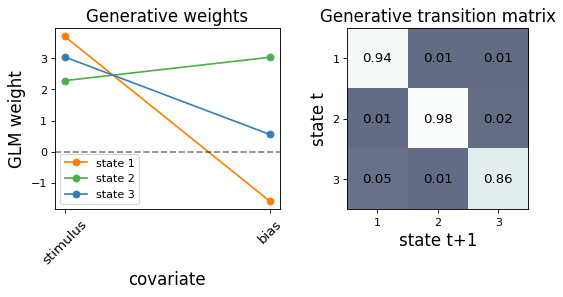

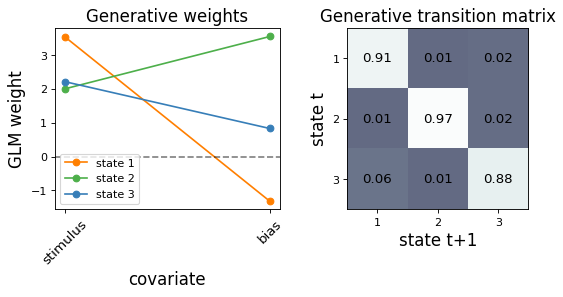

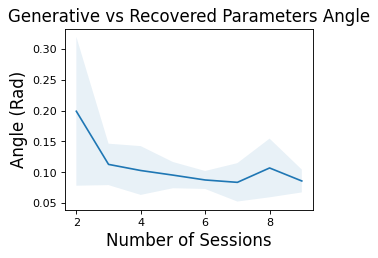

In [15]:
#loop over many different sesion counts and plot L2 distance between the generative model
#parameters and the recovered parameters
num_sess_max = 13
angles = []
#for each ground truth parameter set.. see how many sessions it takes to recover params
for i in range(new_params.shape[0]):
    #initialize ground truth model
    # Set the parameters of the GLM-HMM
    num_states = 3        # number of discrete states
    obs_dim = 1           # number of observed dimensions
    num_categories = 2    # number of categories for output
    input_dim = 2         # input dimensions

    ###### Fit GLM-HMM with MAP estimation:
    # Instantiate GLM-HMM and set prior hyperparameters (MAP version)
    prior_sigma = 2
    prior_alpha = 2

    true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                         observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                         transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
    
    gen_weights = new_params[i,:num_states*input_dim].reshape((num_states,1,input_dim))
    gen_log_trans_mat = new_params[i,num_states*input_dim:].reshape((1,num_states,num_states))
    true_glmhmm.observations.params = gen_weights
    true_glmhmm.transitions.params = gen_log_trans_mat
    
    plotModelParams(true_glmhmm)

    subject_angles = []
    for num_sess in range(2, num_sess_max):
        #Simulate an example set of external inputs for each trial in a session.
        num_trials_per_sess = 500 # number of trials in a session
        inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
        stim_vals = [.98,.75,.62,-.62,-.75,-.98]
        inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
        inpts = list(inpts) #convert inpts to correct format

        # Generate a sequence of latents and choices for each session
        true_latents, true_choices = [], []
        for sess in range(num_sess):
            true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
            true_latents.append(true_z)
            true_choices.append(true_y)

        #instantiate a new GLM-HMM
        new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

        #it new GLM-HMM with MAP estimation:
        N_iters = 400
        new_fit_map_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters,
                                    tolerance=10**-4)

        #first need to permute the states of the fit GLM-HMM relative to the generative model.
        new_glmhmm.permute(find_permutation(np.hstack(true_latents), new_glmhmm.most_likely_states(np.vstack(true_choices), input=np.vstack(inpts))))

        #get generative GLM weights
        generative_weights = true_glmhmm.observations.params.flatten()
        #get recovered GLM weights
        recovered_weights = new_glmhmm.observations.params.flatten()
        #get generative HMM transition matrix
        gen_trans_mat = np.exp(true_glmhmm.transitions.log_Ps).flatten()
        #get recovered HMM transition matrix
        recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps).flatten()
        #concatenate recovered parameters into arrays
        gen_stacked_params = np.hstack([generative_weights, gen_trans_mat])
        rec_stacked_params = np.hstack([recovered_weights, recovered_trans_mat])
        #compute L2 distance between arrays of model parameters
        unit_vector_gen = gen_stacked_params / np.linalg.norm(gen_stacked_params)
        unit_vector_rec = rec_stacked_params / np.linalg.norm(rec_stacked_params)
        dot_product = np.dot(unit_vector_gen, unit_vector_rec)
        angle = np.arccos(dot_product)
        subject_angles.append(angle)
    
    angles.append(subject_angles)


start = 2
max_range = num_sess_max
angles = np.vstack(angles)
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
angle_av = np.mean(angles, axis=0)#calculate average angle for each session number                                                                                                                                                 
se = stats.sem(angles, axis=0)#calculate standard error                                                                                                                                                                                     
n = angles.shape[0]                                                                                                                                                                                                       
confidence=0.95                                                                                                                                                                                                           
h = se * stats.t.ppf((1 + confidence) / 2., n-1)                                                                                                                                                                          
angle_top = angle_av + h#find max loss value for each epoch                                                                                                                                                                     
angle_bottom = angle_av - h#find minimum loss value for each epoch                                                                                                                                                                                                                                                                                                                                              
plt.fill_between(range(start, max_range), (angle_bottom), (angle_top), alpha=.1)  
plt.plot(range(start, max_range), angle_av)
plt.yticks(fontsize=10)
plt.ylabel("Angle (Rad)", fontsize=15)
plt.xlabel("Number of Sessions", fontsize=15)
plt.title("Generative vs Recovered Parameters Angle", fontsize=15)

Text(0.5, 1.0, 'Angle Between Generative and Recovered Parameter Vectors')

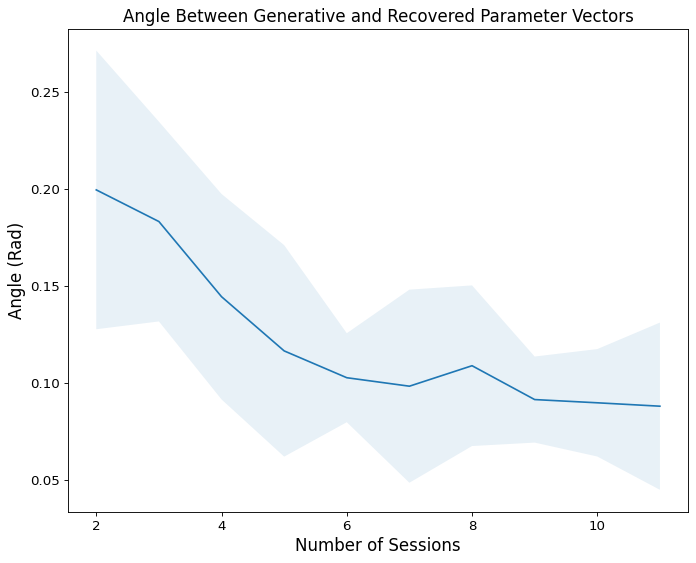

In [24]:
start = 2
max_range = num_sess_max
angles = np.vstack(angles)
fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
angle_av = np.mean(angles, axis=0)#calculate average angle for each session number                                                                                                                                                 
se = stats.sem(angles, axis=0)#calculate standard error                                                                                                                                                                                     
n = angles.shape[0]                                                                                                                                                                                                       
confidence=0.95                                                                                                                                                                                                           
h = se * stats.t.ppf((1 + confidence) / 2., n-1)                                                                                                                                                                          
angle_top = angle_av + h#find max loss value for each epoch                                                                                                                                                                     
angle_bottom = angle_av - h#find minimum loss value for each epoch                                                                                                                                                                                                                                                                                                                                              
plt.fill_between(range(start, max_range), (angle_bottom), (angle_top), alpha=.1)  
plt.plot(range(start, max_range), angle_av)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("Angle (Rad)", fontsize=15)
plt.xlabel("Number of Sessions", fontsize=15)
plt.title("Angle Between Generative and Recovered Parameter Vectors", fontsize=15)

Now iterate across session count to see how many sessions are needed to recover the original number of states for the model selected through model selection.

(1) Model selection using ground truth/generative models only from the real mice (no synthetic versions), use MLE, MAP, BIC (no K Fold).
(2) Once 3 states is reliably recaptured. Fit synthetically generated data with increasing total session count to estimate how many sessions are needed to recapture parameters.
(3) Repeat these steps for the no choice/3 emission model.

In [7]:
#PERFORM FOR NO CHOICE/3 EMISSION MODEL
#num_categories=3


500